<a href="https://colab.research.google.com/github/Kartel7/Moscow_SUHI/blob/en/lcz_time_series_analysis_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyze temperature trends by LCZ (local climate zone) polygons and classes

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_orig = pd.read_csv(r"D:\Kursach_2\analysis\LST_Mean_by_LCZ_ok_en.csv", sep=';')

# Input data: average LST by every LCZ (retrieved through GEE)

In [ ]:
df_orig

# Dataframe view

system:index  lcz  lcz_id  lcz_name   mean_BU    mean_LST  \
0      00000000000000000000_0    1      11  moscvich -0.273184  302.137634   
1      00000000000000000000_1    1      11  moscvich -0.272194  304.176099   
2      00000000000000000000_2    1      11  moscvich -0.256523  303.287335   
3      00000000000000000000_3    1      11  moscvich -0.235384  300.912883   
4      00000000000000000000_4    1      11  moscvich -0.254030  313.794346   
...                       ...  ...     ...       ...       ...         ...   
1515  00000000000000000023_33    8      86   severny -0.387575  306.767366   
1516  00000000000000000023_34    8      86   severny -0.327059  311.132157   
1517  00000000000000000023_35    8      86   severny -0.315141  309.422083   
1518  00000000000000000023_36    8      86   severny -0.350552  304.339523   
1519  00000000000000000023_37    8      86   severny -0.338018  314.156480   

      mean_NDBI                             en_name       rus_name    year  \
0     -0.094475                    Moskvich Factory  Завод Москвич  1984.0   
1     -0.092253                    Moskvich Factory  Завод Москвич  1985.0   
2     -0.092258                    Moskvich Factory  Завод Москвич  1986.0   
3     -0.077059                    Moskvich Factory  Завод Москвич  1987.0   
4     -0.077408                    Moskvich Factory  Завод Москвич  1988.0   
...         ...                                 ...            ...     ...   
1515  -0.147997  Trade and industrial zone Altufevo  ТПЗ Алтуфьево  2020.0   
1516  -0.079645  Trade and industrial zone Altufevo  ТПЗ Алтуфьево  2021.0   
1517  -0.076855  Trade and industrial zone Altufevo  ТПЗ Алтуфьево  2022.0   
1518  -0.091087  Trade and industrial zone Altufevo  ТПЗ Алтуфьево  2023.0   
1519  -0.091853  Trade and industrial zone Altufevo  ТПЗ Алтуфьево  2024.0   

                                        .geo  
0     {"type":"MultiPoint","coordinates":[]}  
1     {"type":"MultiPoint","coordinates":[]}  
2     {"type":"MultiPoint","coordinates":[]}  
3     {"type":"MultiPoint","coordinates":[]}  
4     {"type":"MultiPoint","coordinates":[]}  
...                                      ...  
1515  {"type":"MultiPoint","coordinates":[]}  
1516  {"type":"MultiPoint","coordinates":[]}  
1517  {"type":"MultiPoint","coordinates":[]}  
1518  {"type":"MultiPoint","coordinates":[]}  
1519  {"type":"MultiPoint","coordinates":[]}  

[1520 rows x 11 columns]

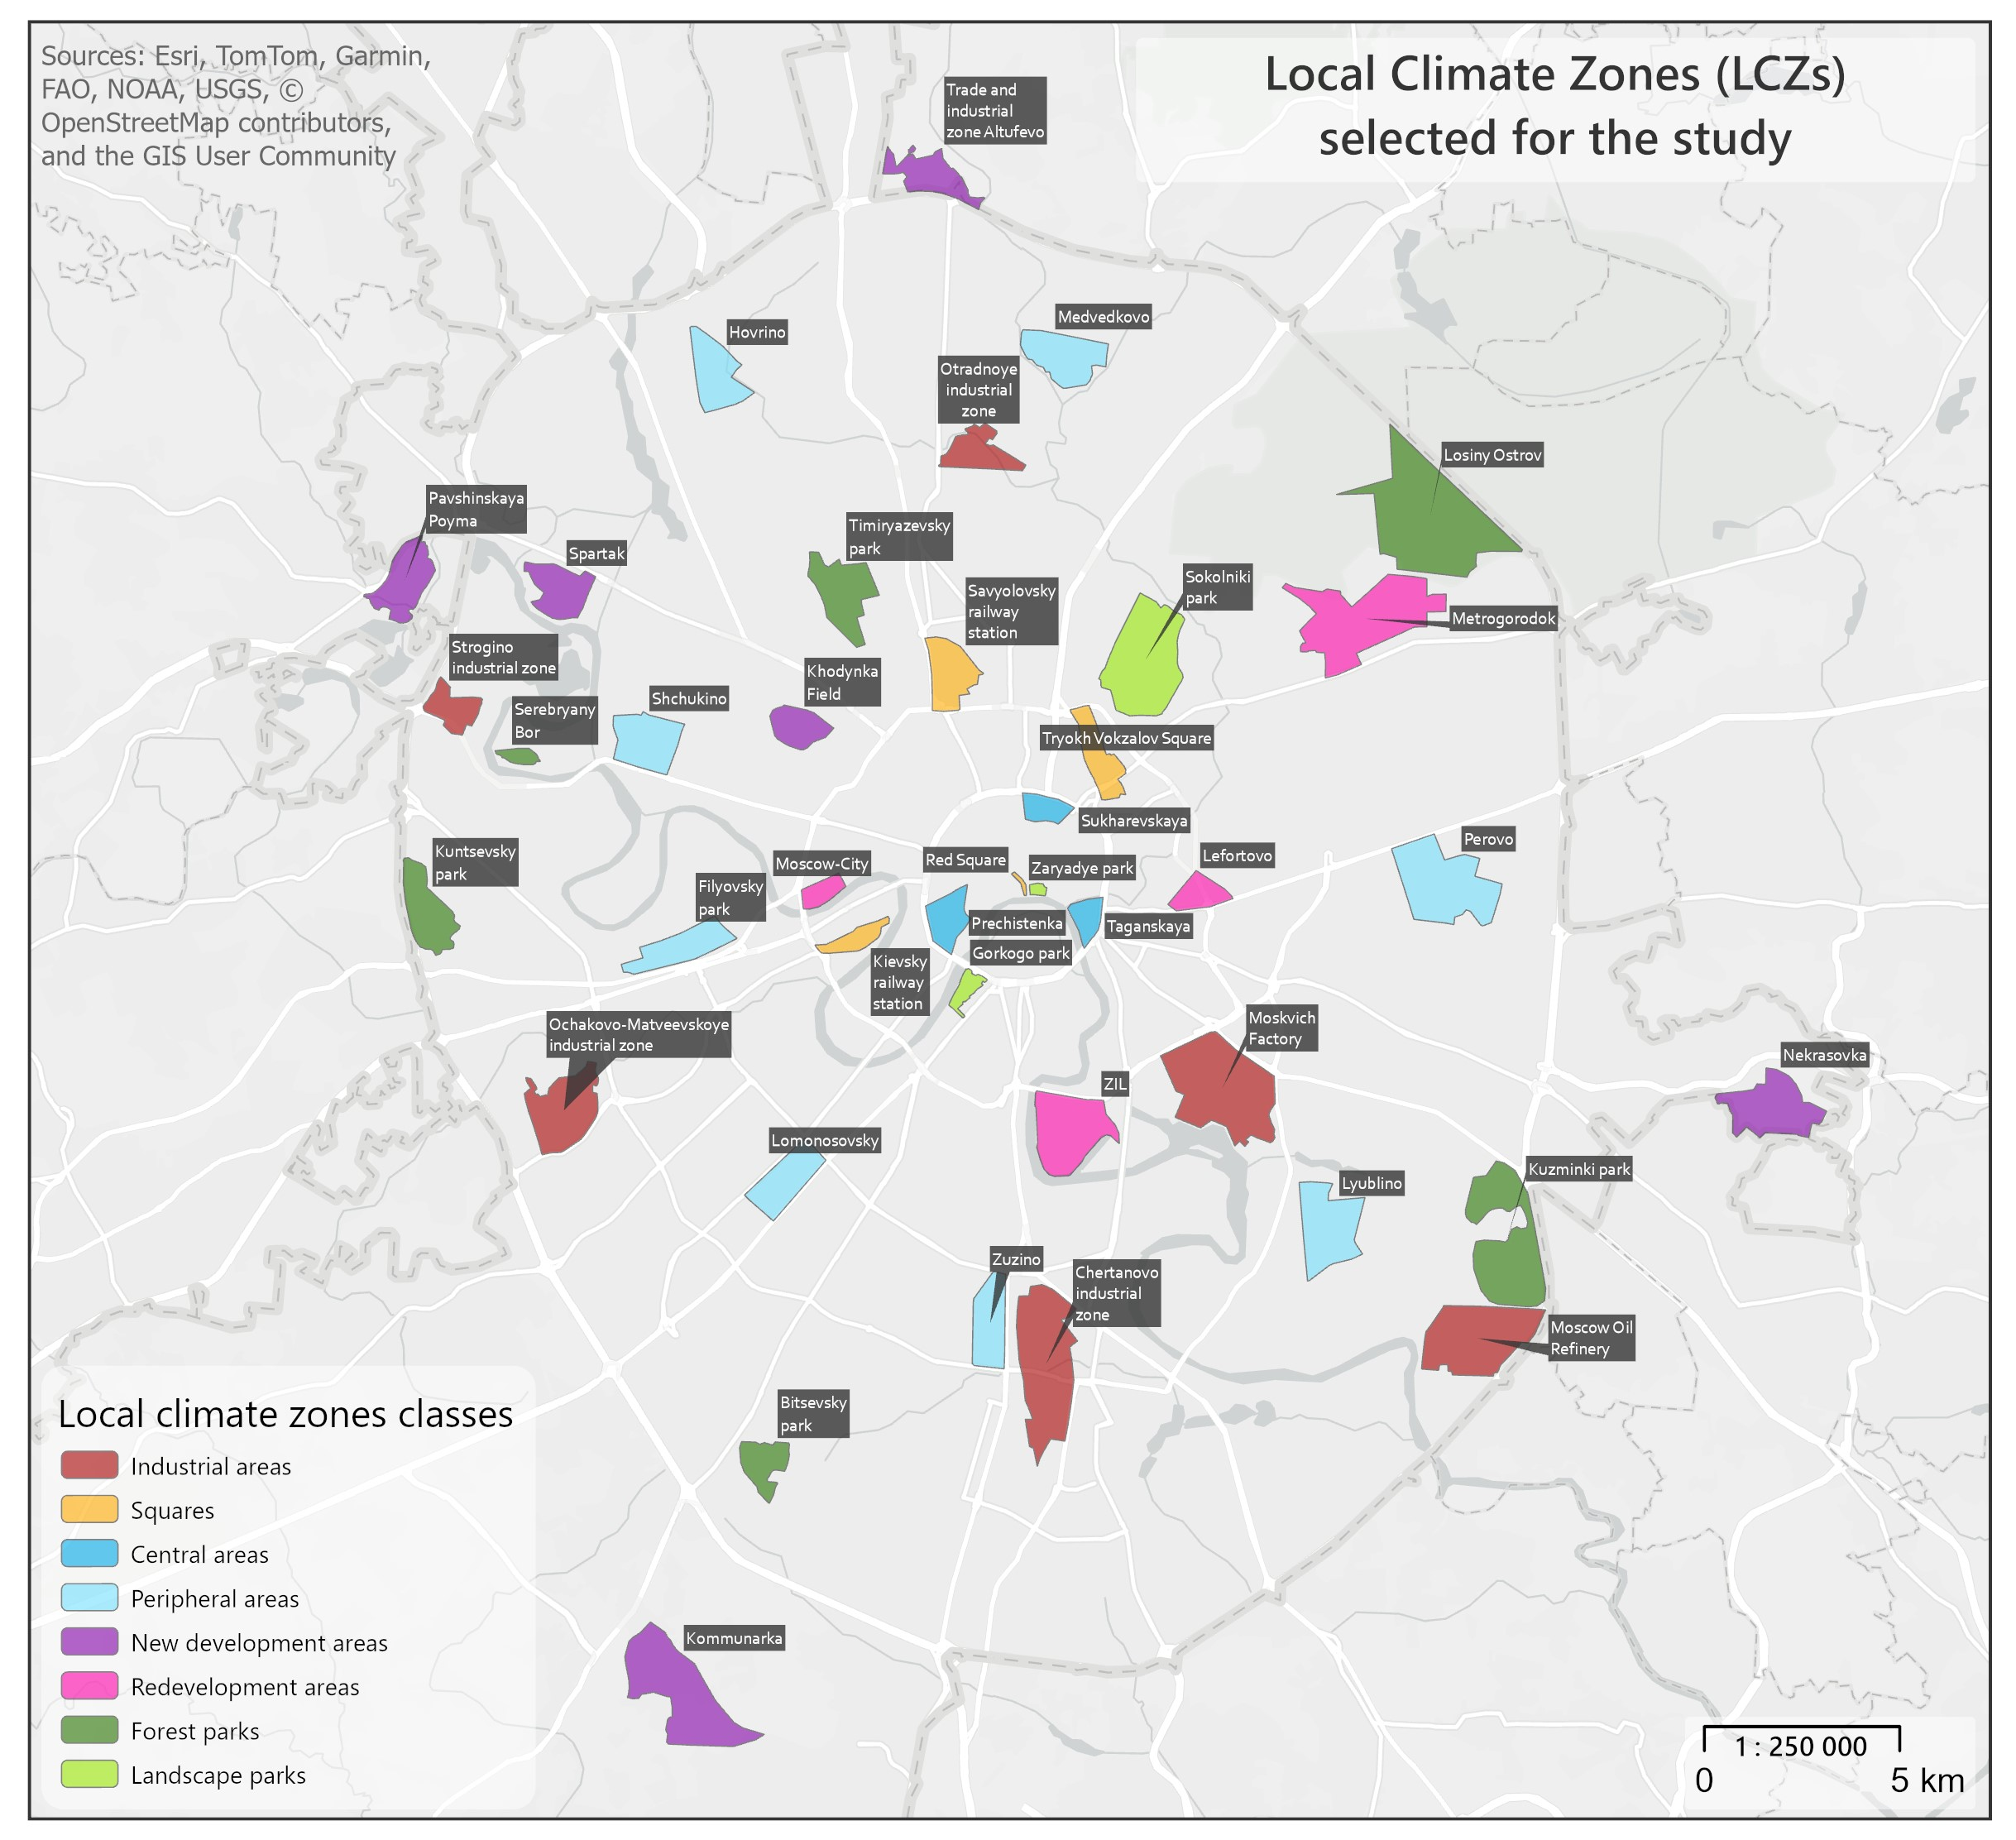

In [ ]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  1520 non-null   object 
 1   lcz           1520 non-null   int64  
 2   lcz_id        1520 non-null   int64  
 3   lcz_name      1520 non-null   object 
 4   mean_BU       1489 non-null   float64
 5   mean_LST      1489 non-null   float64
 6   mean_NDBI     1489 non-null   float64
 7   en_name       1520 non-null   object 
 8   rus_name      1520 non-null   object 
 9   year          1520 non-null   float64
 10  .geo          1520 non-null   object 
dtypes: float64(4), int64(2), object(5)
memory usage: 130.8+ KB


In [ ]:
df = df_orig.drop(['system:index',  '.geo', 'rus_name'], axis=1)

# Drop useless columns

In [ ]:
df['mean_LST'] = df['mean_LST']-273.15

# Kelvin to Celsius

In [ ]:
classes = {1:'Industrial areas', 2:'Squares', 3:'Forest parks', 4:'Central areas', 5:'Peripheral areas',
           6:'Landscape parks', 7:'Redevelopment areas', 8:'New development areas'}

# Classes names according to unique LCZ classes

In [ ]:
df['classname'] = df['lcz'].apply(lambda classid: classes[classid])

# Assigning class names to each polygon

In [ ]:
df.sample(5)

lcz  lcz_id      lcz_name   mean_BU   mean_LST  mean_NDBI  \
596     3      36  timiryazevka -1.067551  20.492552  -0.381057   
1072    6      62       gorkogo -0.591192  26.845725  -0.234114   
1314    8      81       hodynka -0.135928  22.142981  -0.029563   
439     3      32         bitza -1.027438  23.508719  -0.360541   
827     5      53       lublino -0.647250  28.479531  -0.234293   

                 en_name    year              classname  
596   Timiryazevsky park  2013.0           Forest parks  
1072        Gorkogo park  1992.0        Landscape parks  
1314      Khodynka Field  2008.0  New development areas  
439       Bitsevsky park  2007.0           Forest parks  
827             Lyublino  2016.0       Peripheral areas

In [ ]:
df['year'] = df['year'].astype(int)

# Years to integer

In [ ]:
polygons_id = df['lcz_id'].unique()
polygons_id

# Unique numbers of LCZ polygons

array([11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 31, 32, 33, 34, 35, 36, 41,
       42, 43, 51, 52, 53, 54, 55, 56, 57, 58, 61, 62, 63, 71, 72, 73, 74,
       81, 82, 83, 84, 85, 86], dtype=int64)

In [ ]:
classes = df['lcz'].unique()
classes

# Unique classes numbers

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [ ]:
df['mean_LST'].isna().sum()/len(df)*100

# NaN percent

2.0394736842105265

In [ ]:
df.corr(numeric_only=True)[['mean_LST', 'mean_BU']].loc['mean_LST']

# Pearson corr between LST and и BU-index = 0.68

mean_LST    1.000000
mean_BU     0.682457
Name: mean_LST, dtype: float64

## Linear trend check based on the raw data

Calculate and plot linear trend

In [ ]:
df_clean = df.dropna(subset=['mean_LST'])

# Drop empty data

In [ ]:
df_clean = df_clean.reset_index()
df_clean = df_clean.set_index('lcz_id')

# Look through polygons

In [ ]:
df_clean

index  lcz  lcz_name   mean_BU   mean_LST  mean_NDBI  \
lcz_id                                                         
11          0    1  moscvich -0.273184  28.987634  -0.094475   
11          1    1  moscvich -0.272194  31.026099  -0.092253   
11          2    1  moscvich -0.256523  30.137335  -0.092258   
11          3    1  moscvich -0.235384  27.762883  -0.077059   
11          4    1  moscvich -0.254030  40.644346  -0.077408   
...       ...  ...       ...       ...        ...        ...   
86       1515    8   severny -0.387575  33.617366  -0.147997   
86       1516    8   severny -0.327059  37.982157  -0.079645   
86       1517    8   severny -0.315141  36.272083  -0.076855   
86       1518    8   severny -0.350552  31.189523  -0.091087   
86       1519    8   severny -0.338018  41.006480  -0.091853   

                                   en_name  year              classname  
lcz_id                                                                   
11                        Moskvich Factory  1984       Industrial areas  
11                        Moskvich Factory  1985       Industrial areas  
11                        Moskvich Factory  1986       Industrial areas  
11                        Moskvich Factory  1987       Industrial areas  
11                        Moskvich Factory  1988       Industrial areas  
...                                    ...   ...                    ...  
86      Trade and industrial zone Altufevo  2020  New development areas  
86      Trade and industrial zone Altufevo  2021  New development areas  
86      Trade and industrial zone Altufevo  2022  New development areas  
86      Trade and industrial zone Altufevo  2023  New development areas  
86      Trade and industrial zone Altufevo  2024  New development areas  

[1489 rows x 9 columns]

Graph example

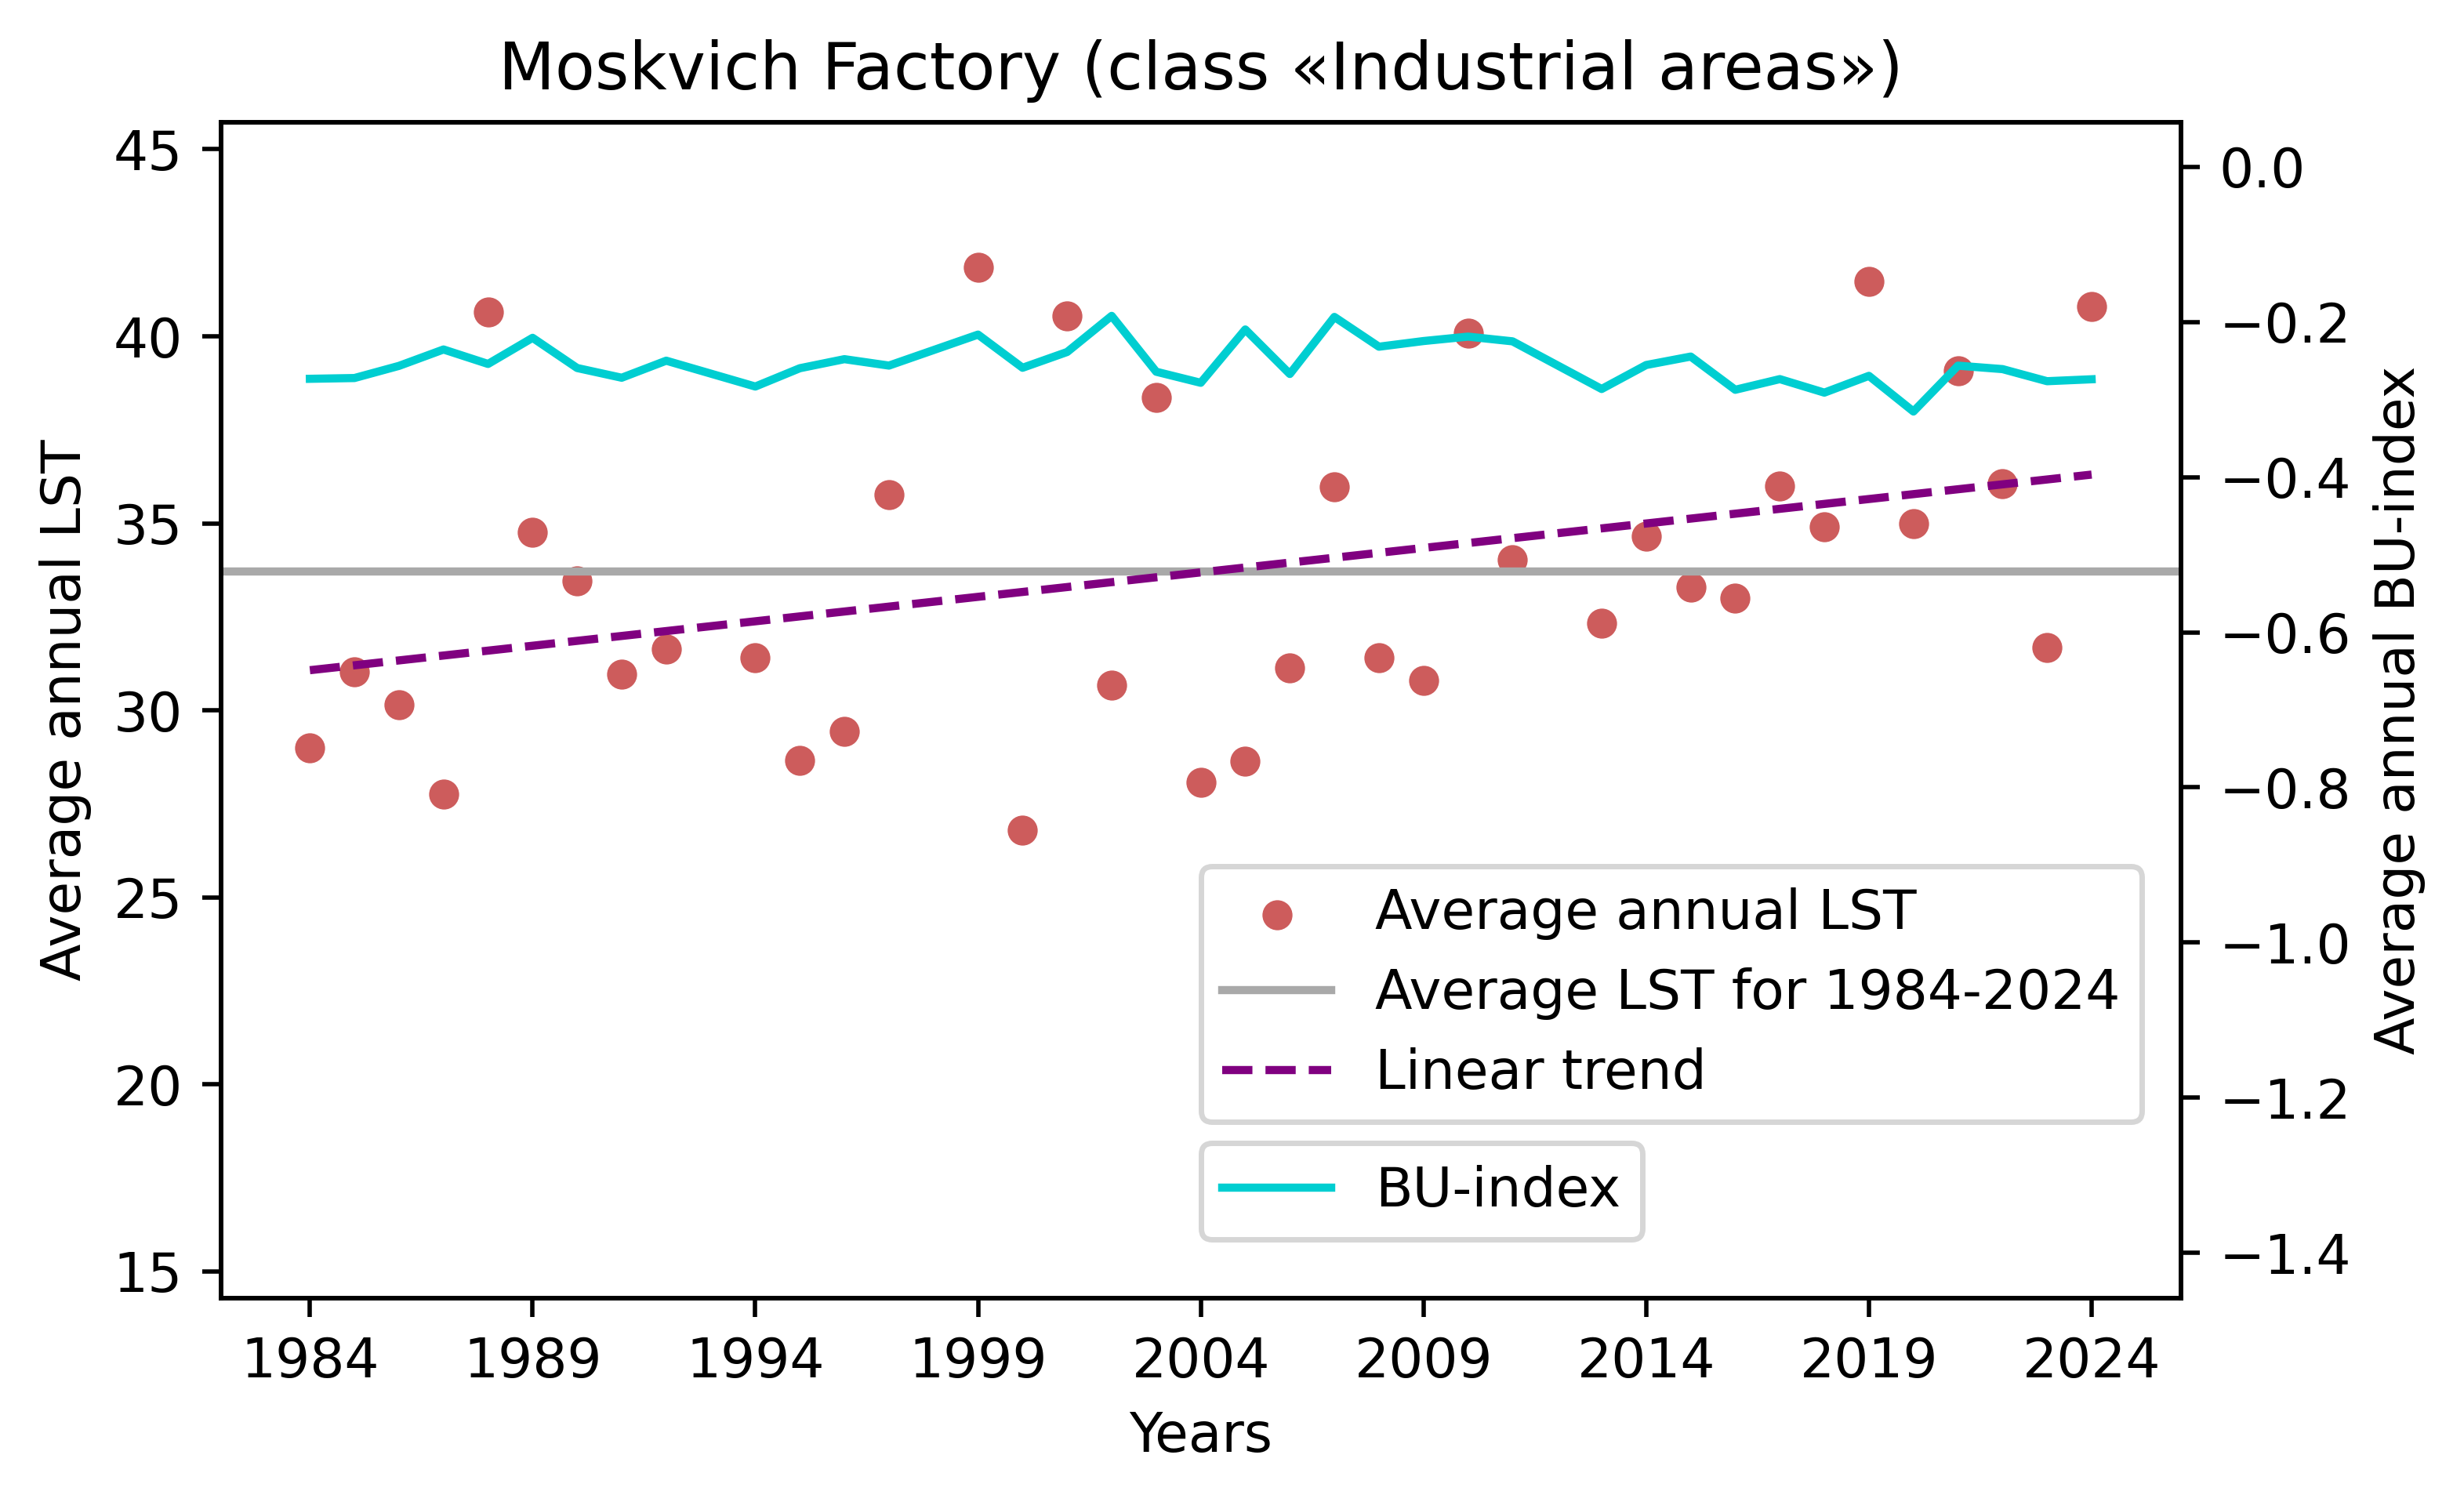

In [ ]:
# Example visualization

ts_poly_df_clean = df_clean.loc[11]

x = ts_poly_df_clean['year']
years_ticks = np.arange(x.min(), x.max()+1, 5)

y = ts_poly_df_clean['mean_LST']
ymin = df_clean['mean_LST'].min() - 1
ymax = df_clean['mean_LST'].max() + 2

y2 = ts_poly_df_clean['mean_BU']
y2min = df_clean['mean_BU'].min() - 0.2
y2max = df_clean['mean_BU'].max() + 0.1

fig = plt.figure(figsize=(5,3), dpi=500)
ax1 = fig.add_axes([0,0,1,1])
ax1.set_ylim(ymin, ymax)

sns.scatterplot(x=x, y=y, ax=ax1, color='indianred')
ax1.axhline(y.mean(), color='darkgrey')

coeffs = np.polyfit(x, y, 1)
polynomial = np.poly1d(coeffs)
ax1.plot(x, polynomial(x), color='purple', ls='--')
ax1.set_xlabel('Years')
ax1.set_xticks(years_ticks)
ax1.set_ylabel('Average annual LST')
plt.legend(['Average annual LST','Average LST for 1984-2024','Linear trend'], loc=[0.5,0.15])

ax2 = ax1.twinx()
ax2.set_ylim(y2min,y2max)
ax2.set_ylabel('Average annual BU-index')
sns.lineplot(x=x, y=y2, ax=ax2, color='darkturquoise')
plt.legend(['BU-index'], loc=[0.5,0.05])

title = plt.title(f'{ts_poly_df_clean["en_name"].iloc[0]} (class «{ts_poly_df_clean["classname"].iloc[0]}»)')
# plt.tight_layout()
# plt.savefig(f'D:\Kursach_2\comps\plots\{title}.png', bbox_inches='tight')
plt.show()

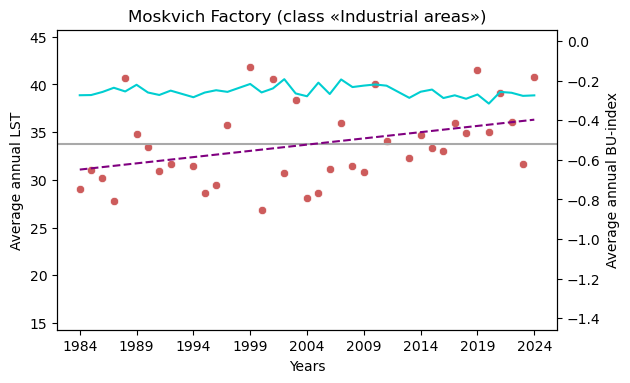

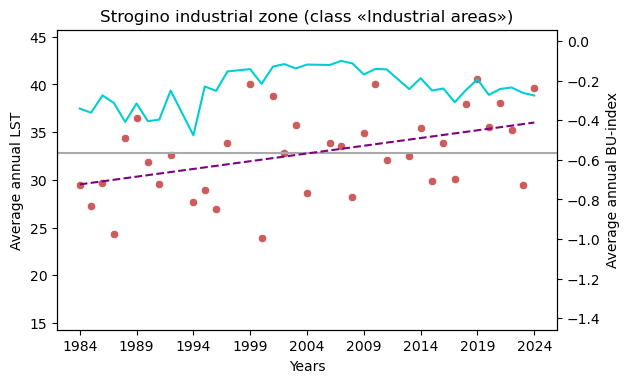

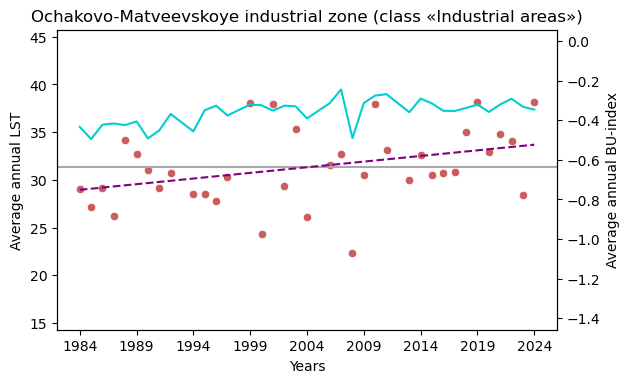

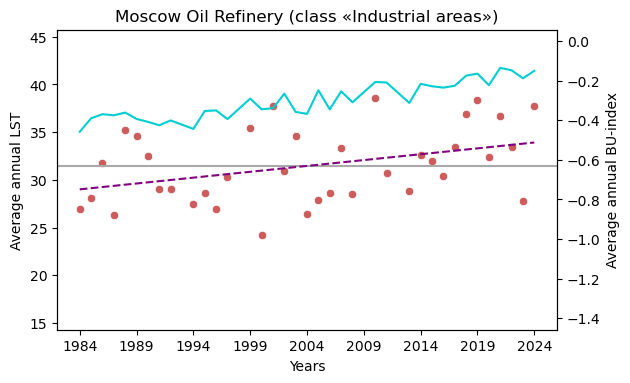

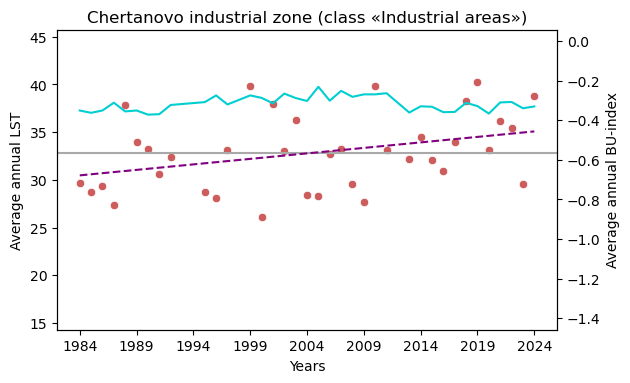

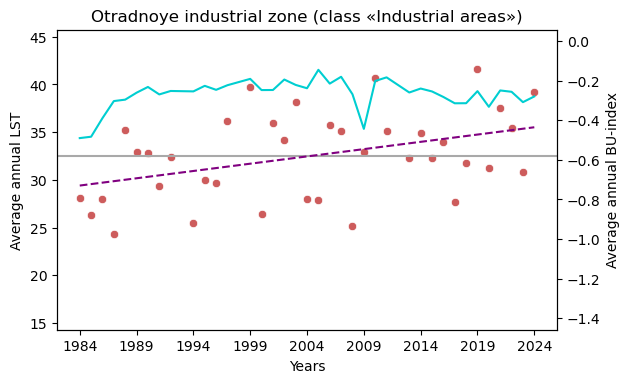

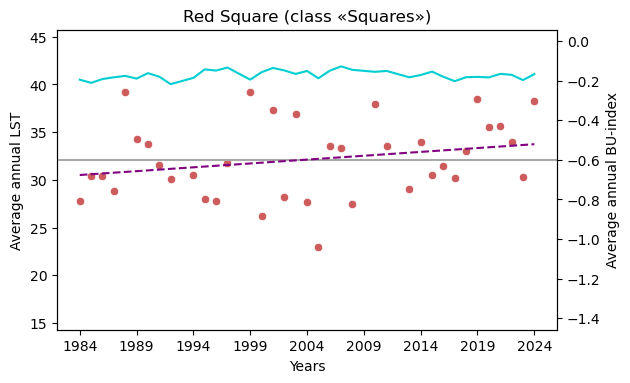

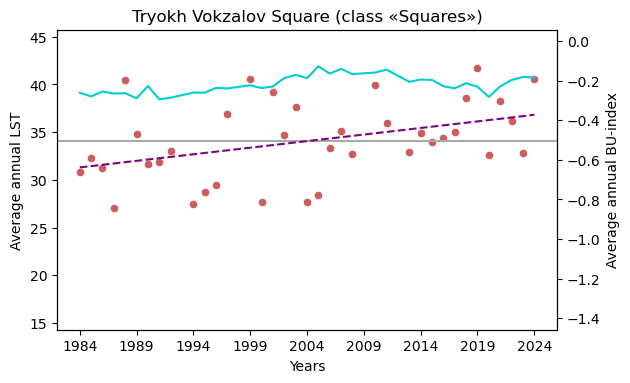

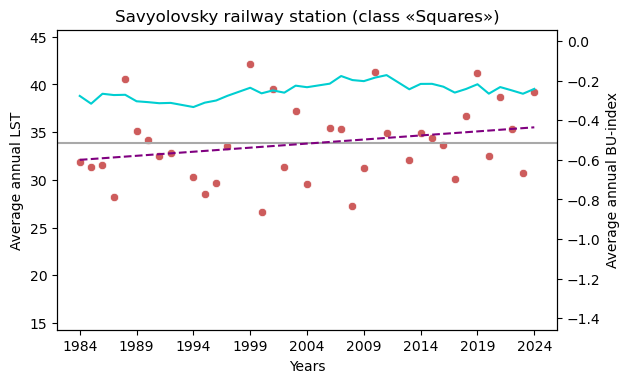

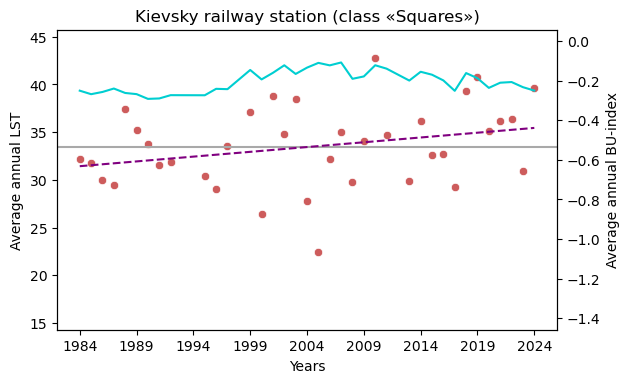

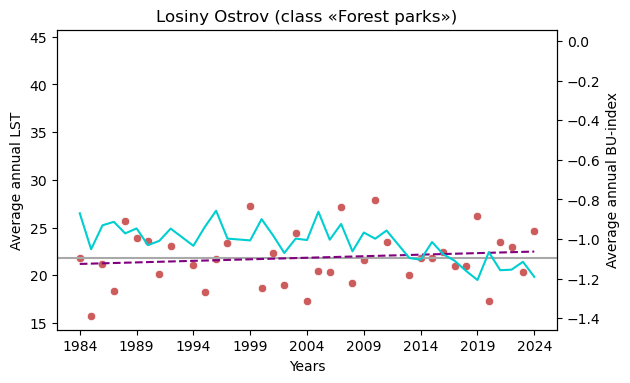

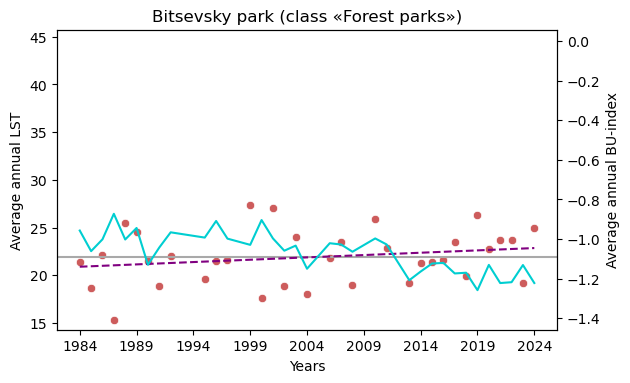

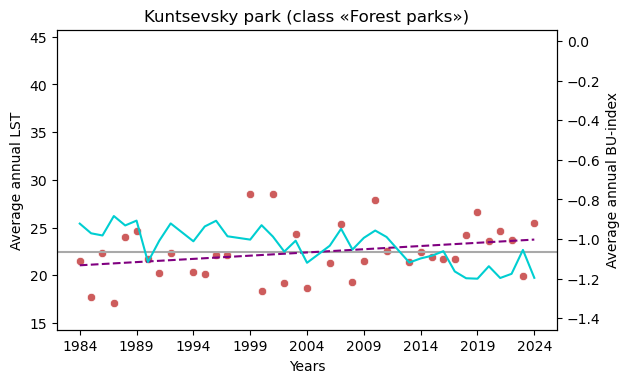

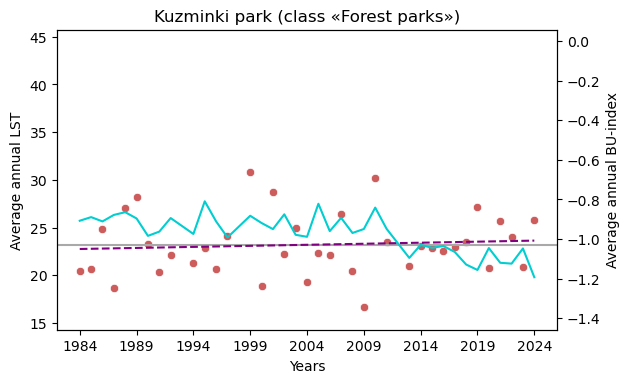

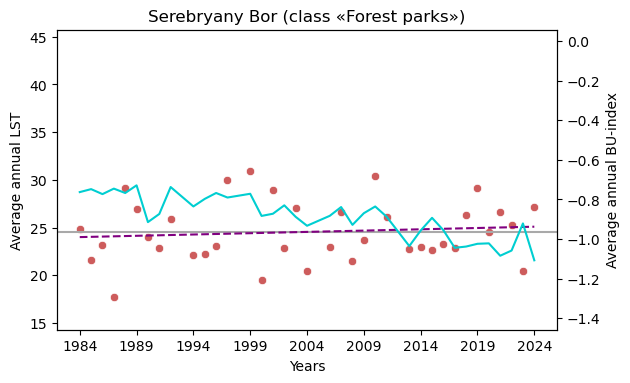

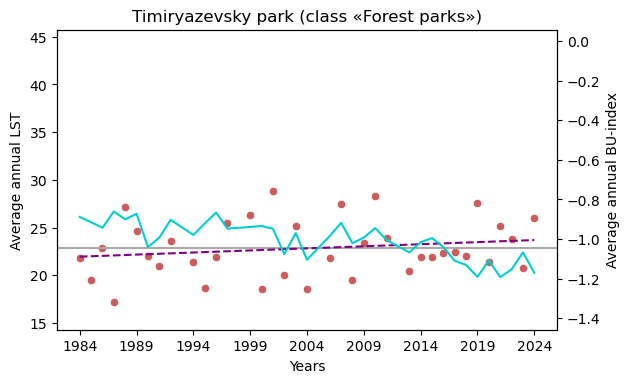

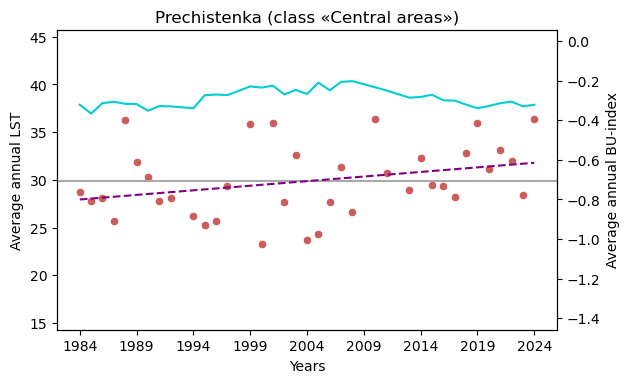

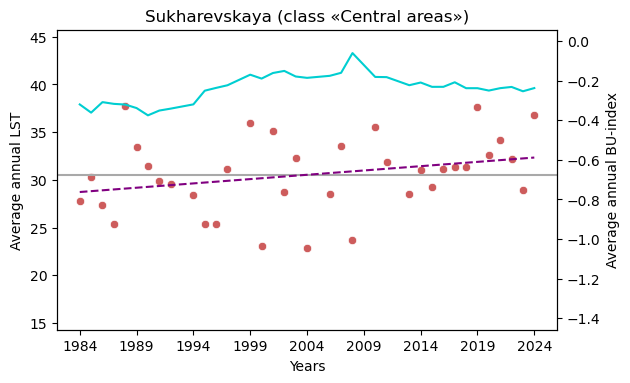

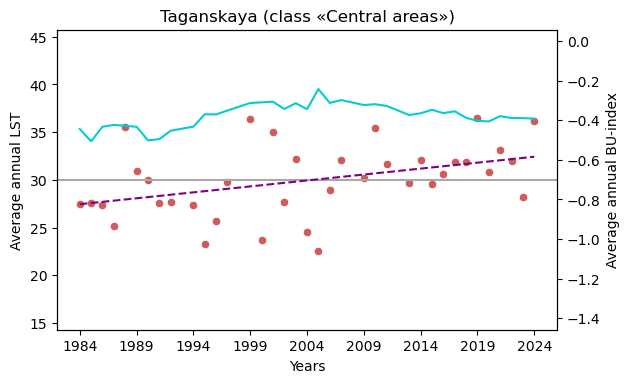

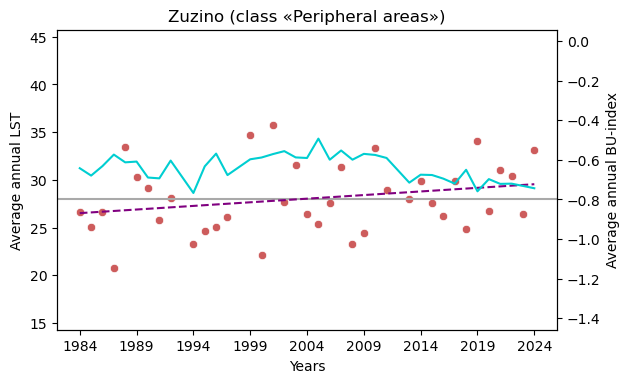

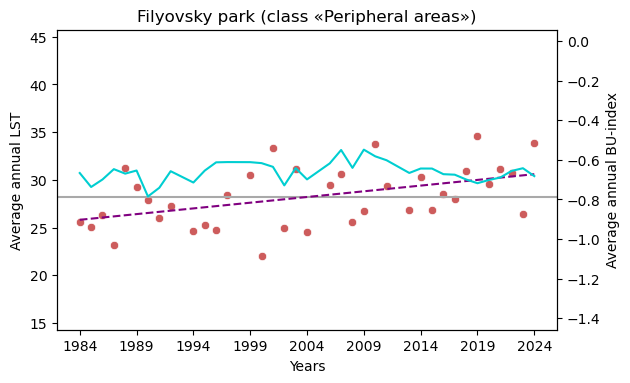

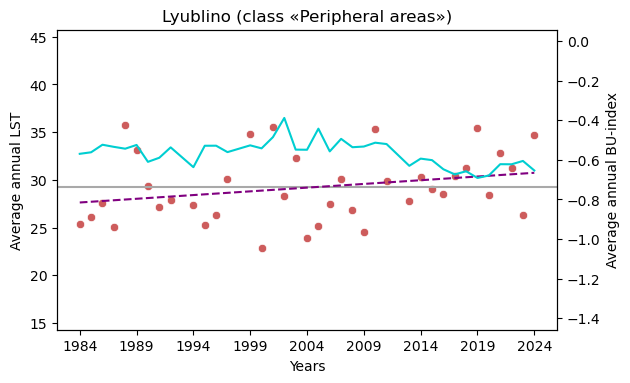

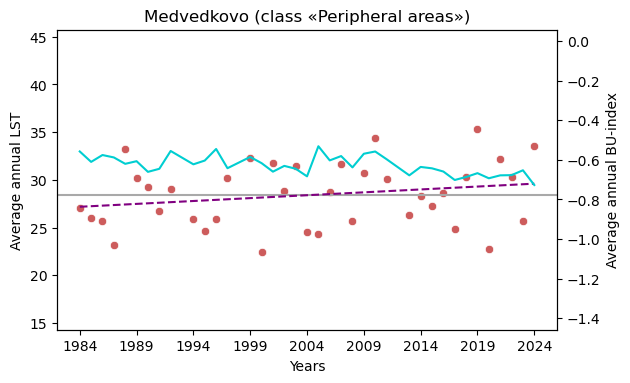

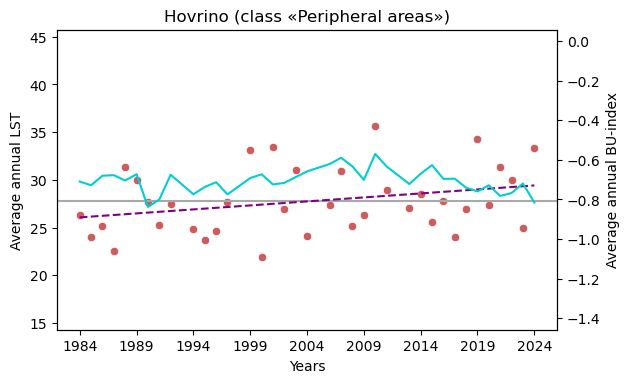

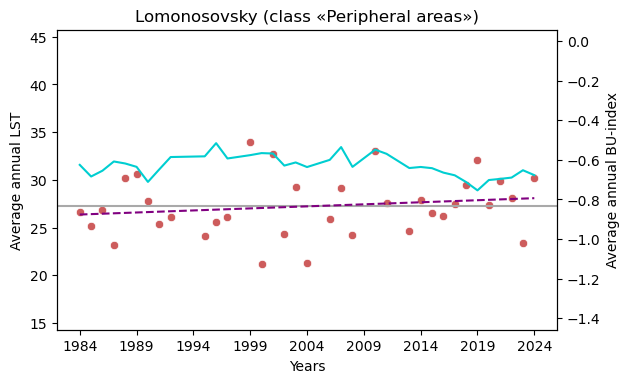

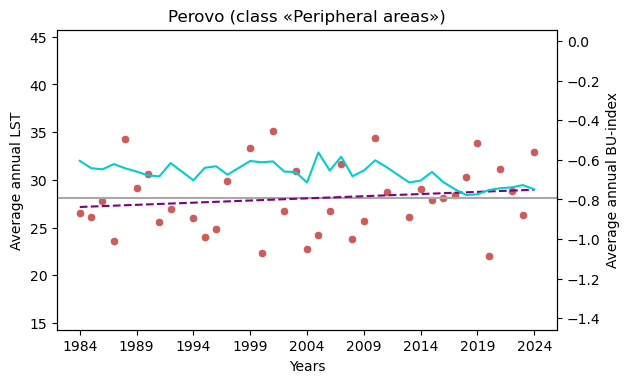

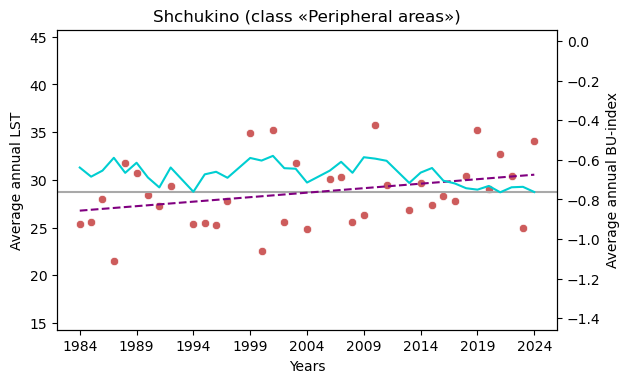

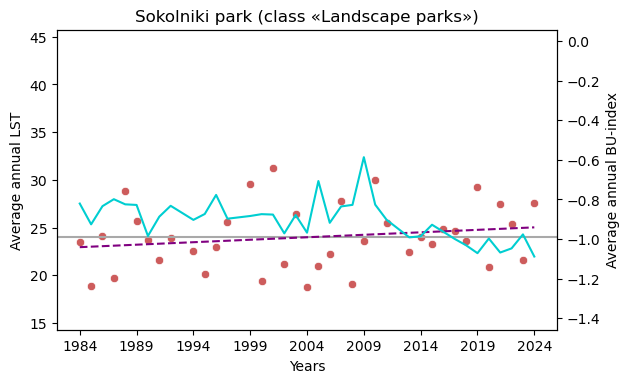

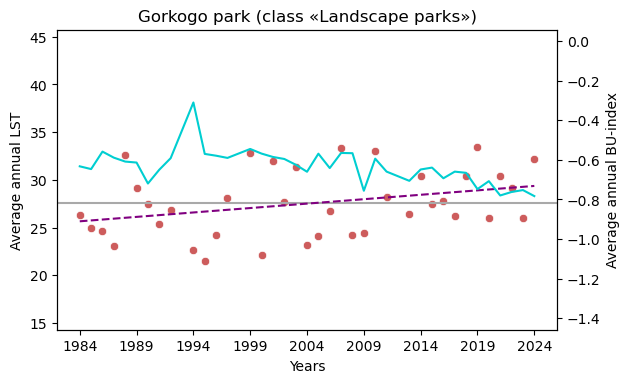

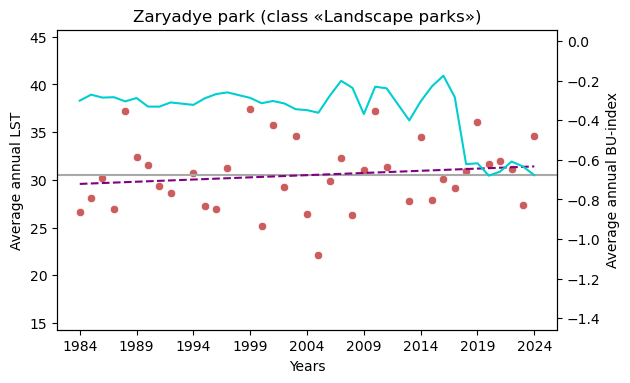

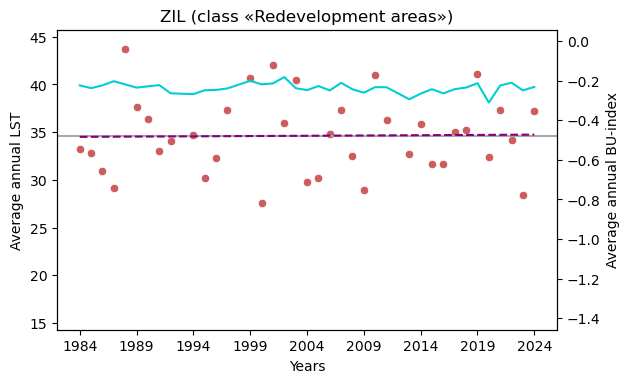

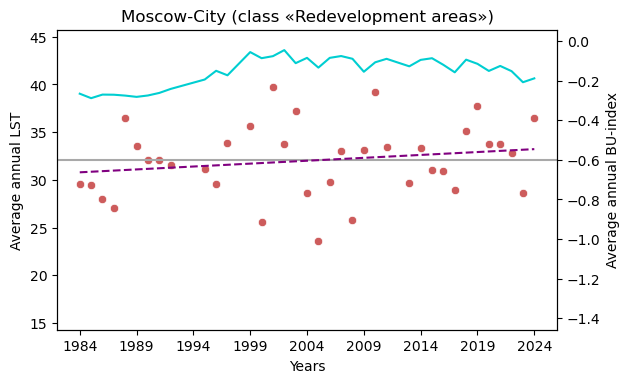

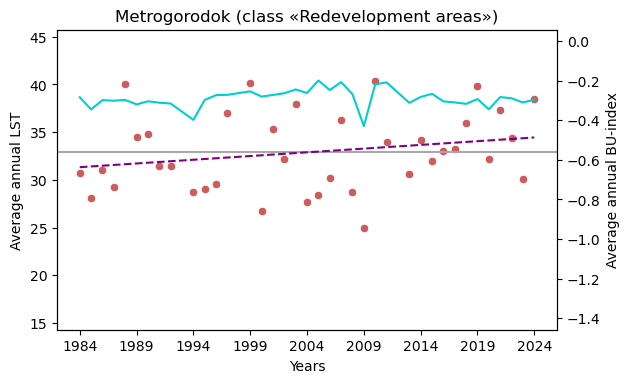

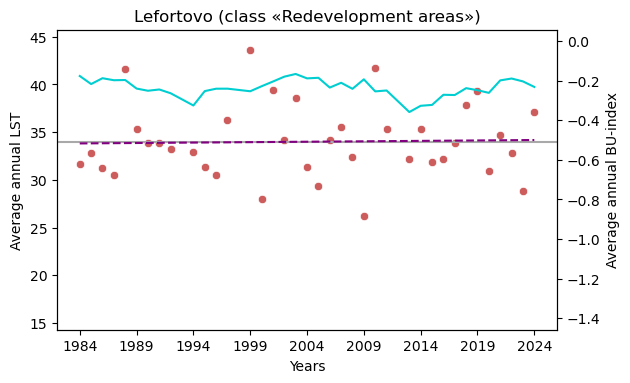

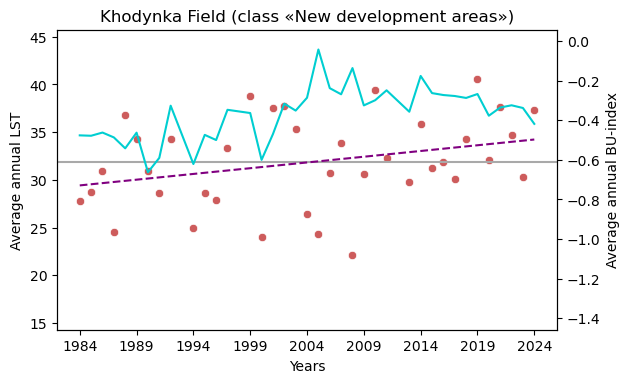

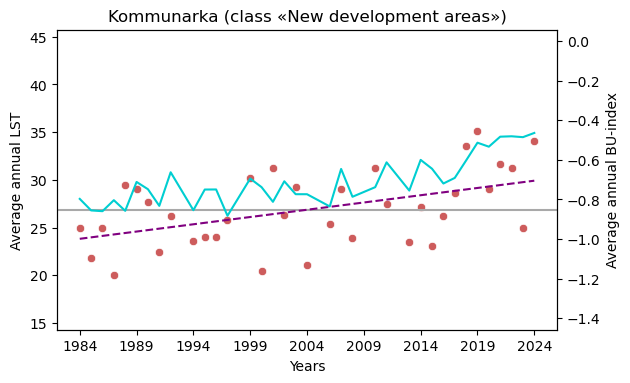

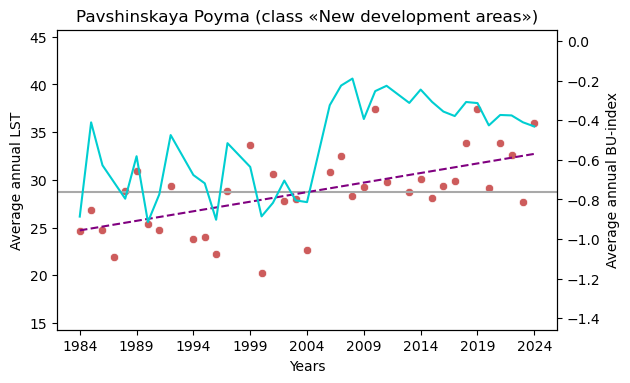

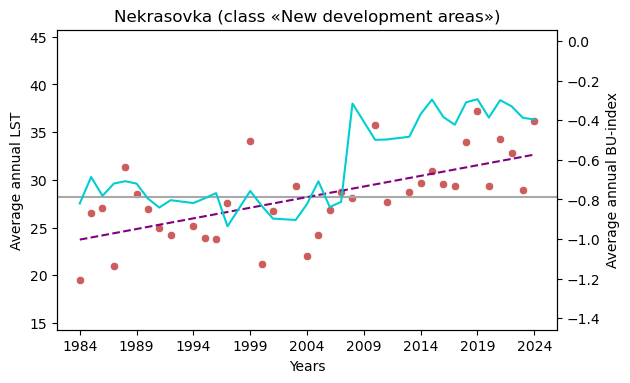

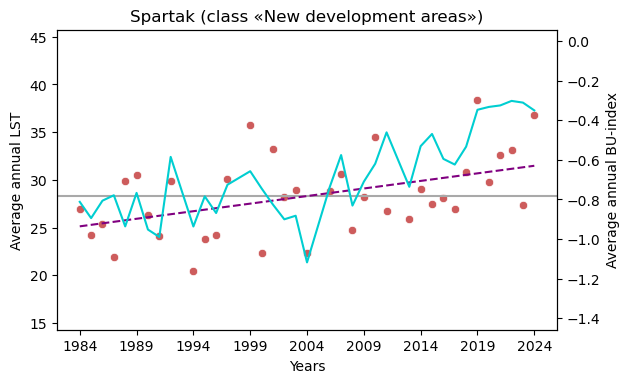

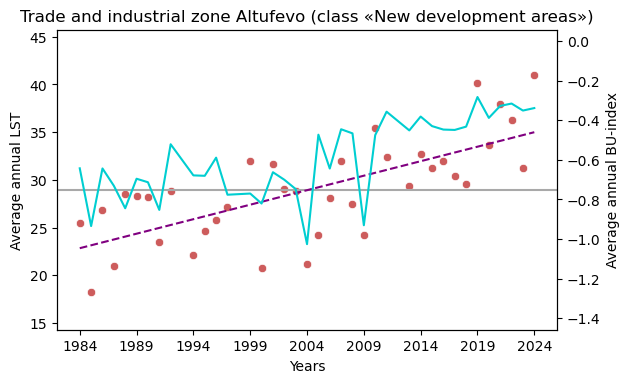

In [ ]:
for ID in polygons_id:

    ts_poly_df_clean = df_clean.loc[ID]

    x = ts_poly_df_clean['year']
    years_ticks = np.arange(x.min(), x.max()+1, 5)

    y = ts_poly_df_clean['mean_LST']
    ymin = df_clean['mean_LST'].min() - 1
    ymax = df_clean['mean_LST'].max() + 2

    y2 = ts_poly_df_clean['mean_BU']
    y2min = df_clean['mean_BU'].min() - 0.2
    y2max = df_clean['mean_BU'].max() + 0.1

    fig = plt.figure(figsize=(5,3))
    ax1 = fig.add_axes([0,0,1,1])
    ax1.set_ylim(ymin, ymax)

    sns.scatterplot(x=x, y=y, ax=ax1, color='indianred')
    ax1.axhline(y.mean(), color='darkgrey')

    coeffs = np.polyfit(x, y, 1)
    polynomial = np.poly1d(coeffs)
    ax1.plot(x, polynomial(x), color='purple', ls='--')
    ax1.set_xlabel('Years')
    ax1.set_xticks(years_ticks)
    ax1.set_ylabel('Average annual LST')

    ax2 = ax1.twinx()
    ax2.set_ylim(y2min,y2max)
    ax2.set_ylabel('Average annual BU-index')
    sns.lineplot(x=x, y=y2, ax=ax2, color='darkturquoise')

    title = plt.title(f'{ts_poly_df_clean["en_name"].iloc[0]} (class «{ts_poly_df_clean["classname"].iloc[0]}»)')
   # plt.tight_layout()
   # plt.savefig(f'D:\Kursach_2\comps\plots\{title}.png', bbox_inches='tight')
    plt.show()

Statistical test of trend significance

In [ ]:
df_clean

index  lcz  lcz_name   mean_BU   mean_LST  mean_NDBI  \
lcz_id                                                         
11          0    1  moscvich -0.273184  28.987634  -0.094475   
11          1    1  moscvich -0.272194  31.026099  -0.092253   
11          2    1  moscvich -0.256523  30.137335  -0.092258   
11          3    1  moscvich -0.235384  27.762883  -0.077059   
11          4    1  moscvich -0.254030  40.644346  -0.077408   
...       ...  ...       ...       ...        ...        ...   
86       1515    8   severny -0.387575  33.617366  -0.147997   
86       1516    8   severny -0.327059  37.982157  -0.079645   
86       1517    8   severny -0.315141  36.272083  -0.076855   
86       1518    8   severny -0.350552  31.189523  -0.091087   
86       1519    8   severny -0.338018  41.006480  -0.091853   

                                   en_name  year              classname  
lcz_id                                                                   
11                        Moskvich Factory  1984       Industrial areas  
11                        Moskvich Factory  1985       Industrial areas  
11                        Moskvich Factory  1986       Industrial areas  
11                        Moskvich Factory  1987       Industrial areas  
11                        Moskvich Factory  1988       Industrial areas  
...                                    ...   ...                    ...  
86      Trade and industrial zone Altufevo  2020  New development areas  
86      Trade and industrial zone Altufevo  2021  New development areas  
86      Trade and industrial zone Altufevo  2022  New development areas  
86      Trade and industrial zone Altufevo  2023  New development areas  
86      Trade and industrial zone Altufevo  2024  New development areas  

[1489 rows x 9 columns]

In [ ]:
results = []

for poly_id in polygons_id:

    # Filter by polygon
    ts_poly = df_clean.loc[poly_id]

    x = ts_poly['year'].values
    y = ts_poly['mean_LST'].values

    # Linear regression
    slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

    # Save a result
    results.append({
        'class': ts_poly['lcz'].iloc[0],
        'lcz_id': poly_id,
        'lcz_name': ts_poly['en_name'].iloc[0],  # Get the first row as name
        'n_points': len(ts_poly),
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value,
        'p_value': p_value,
        'std_err': std_err
    })

# To DataFrame
results_df = pd.DataFrame(results)

In [ ]:
results_df

class  lcz_id                               lcz_name  n_points     slope  \
0       1      11                       Moskvich Factory        38  0.130765   
1       1      12               Strogino industrial zone        37  0.162024   
2       1      13  Ochakovo-Matveevskoye industrial zone        37  0.118237   
3       1      14                    Moscow Oil Refinery        37  0.122761   
4       1      15             Chertanovo industrial zone        37  0.115194   
5       1      16              Otradnoye industrial zone        38  0.152717   
6       2      21                             Red Square        37  0.080689   
7       2      22                 Tryokh Vokzalov Square        37  0.137777   
8       2      23            Savyolovsky railway station        37  0.085237   
9       2      24                Kievsky railway station        37  0.100271   
10      3      31                          Losiny Ostrov        38  0.032433   
11      3      32                         Bitsevsky park        35  0.048910   
12      3      33                        Kuntsevsky park        37  0.067380   
13      3      34                          Kuzminki park        38  0.021938   
14      3      35                         Serebryany Bor        37  0.027254   
15      3      36                     Timiryazevsky park        37  0.043503   
16      4      41                           Prechistenka        37  0.096228   
17      4      42                          Sukharevskaya        36  0.090310   
18      4      43                             Taganskaya        37  0.124449   
19      5      51                                 Zuzino        38  0.075756   
20      5      52                         Filyovsky park        37  0.119509   
21      5      53                               Lyublino        38  0.077787   
22      5      54                             Medvedkovo        38  0.060555   
23      5      55                                Hovrino        37  0.083722   
24      5      56                           Lomonosovsky        35  0.042830   
25      5      57                                 Perovo        38  0.045228   
26      5      58                              Shchukino        37  0.094206   
27      6      61                         Sokolniki park        38  0.051869   
28      6      62                           Gorkogo park        38  0.092662   
29      6      63                          Zaryadye park        38  0.045837   
30      7      71                                    ZIL        38  0.005899   
31      7      72                            Moscow-City        37  0.060716   
32      7      73                           Metrogorodok        38  0.077804   
33      7      74                              Lefortovo        38  0.008949   
34      8      81                         Khodynka Field        38  0.120236   
35      8      82                             Kommunarka        36  0.152229   
36      8      83                     Pavshinskaya Poyma        37  0.200457   
37      8      84                             Nekrasovka        36  0.222683   
38      8      85                                Spartak        37  0.158696   
39      8      86     Trade and industrial zone Altufevo        38  0.303915   

     intercept   r_value       p_value   std_err  
0  -228.365502  0.375792  2.006672e-02  0.053744  
1  -291.936446  0.451539  5.027605e-03  0.054117  
2  -205.631368  0.370808  2.386184e-02  0.050055  
3  -214.558833  0.390669  1.681825e-02  0.048894  
4  -198.080149  0.358904  2.914978e-02  0.050638  
5  -273.592570  0.411191  1.032830e-02  0.056425  
6  -129.584444  0.247991  1.388938e-01  0.053280  
7  -242.051247  0.413057  1.105716e-02  0.051347  
8  -137.018483  0.257951  1.232152e-01  0.053964  
9  -167.510994  0.288416  8.342397e-02  0.056268  
10  -43.166169  0.137782  4.094184e-01  0.038858  
11  -76.148225  0.214964  2.149330e-01  0.038682  
12 -112.641972  0.292617  7.882809e-02  0.037218  
13  -20.7

In [ ]:
nonvalid_poly = results_df[results_df['p_value']>0.05]

In [ ]:
nonvalid_poly.groupby('class').count()['p_value']

# Number of polygons with insignificant trend at significance level 0.05

class
2    3
3    6
4    2
5    6
6    2
7    4
8    1
Name: p_value, dtype: int64

In [ ]:
valid_poly = results_df[results_df['p_value']<0.05].sort_values('slope', ascending=False)

In [ ]:
valid_poly.groupby('class').count()['p_value']

# Number of polygons with significant trend at significance level 0.05

class
1    6
2    1
4    1
5    2
6    1
8    5
Name: p_value, dtype: int64

In [ ]:
print('Percentage of polygons with insignificant trend:', len(results_df[results_df['p_value']>0.05])/len(results_df)*100)

Percentage of polygons with insignificant trend: 60.0


In [ ]:
results_df[results_df['p_value']<0.05].sort_values('slope',ascending=False)

# Polygons with significant trend

class  lcz_id                               lcz_name  n_points     slope  \
39      8      86     Trade and industrial zone Altufevo        38  0.303915   
37      8      84                             Nekrasovka        36  0.222683   
36      8      83                     Pavshinskaya Poyma        37  0.200457   
1       1      12               Strogino industrial zone        37  0.162024   
38      8      85                                Spartak        37  0.158696   
5       1      16              Otradnoye industrial zone        38  0.152717   
35      8      82                             Kommunarka        36  0.152229   
7       2      22                 Tryokh Vokzalov Square        37  0.137777   
0       1      11                       Moskvich Factory        38  0.130765   
18      4      43                             Taganskaya        37  0.124449   
3       1      14                    Moscow Oil Refinery        37  0.122761   
20      5      52                         Filyovsky park        37  0.119509   
2       1      13  Ochakovo-Matveevskoye industrial zone        37  0.118237   
4       1      15             Chertanovo industrial zone        37  0.115194   
26      5      58                              Shchukino        37  0.094206   
28      6      62                           Gorkogo park        38  0.092662   

     intercept   r_value       p_value   std_err  
39 -580.134609  0.705110  7.709641e-07  0.050939  
37 -418.071050  0.637175  2.930977e-05  0.046194  
36 -373.007838  0.588290  1.284860e-04  0.046575  
1  -291.936446  0.451539  5.027605e-03  0.054117  
38 -289.729726  0.463757  3.840138e-03  0.051246  
5  -273.592570  0.411191  1.032830e-02  0.056425  
35 -278.204923  0.489584  2.441112e-03  0.046497  
7  -242.051247  0.413057  1.105716e-02  0.051347  
0  -228.365502  0.375792  2.006672e-02  0.053744  
18 -219.465923  0.411370  1.142314e-02  0.046609  
3  -214.558833  0.390669  1.681825e-02  0.048894  
20 -211.298563  0.471593  3.214068e-03  0.037773  
2  -205.631368  0.370808  2.386184e-02  0.050055  
4  -198.080149  0.358904  2.914978e-02  0.050638  
26 -160.137307  0.326271  4.874503e-02  0.046134  
28 -158.190727  0.327939  4.443256e-02  0.044489

In [ ]:
results_df[results_df['p_value']>0.05].sort_values('slope',ascending=False)

class  lcz_id                     lcz_name  n_points     slope  \
34      8      81               Khodynka Field        38  0.120236   
9       2      24      Kievsky railway station        37  0.100271   
16      4      41                 Prechistenka        37  0.096228   
17      4      42                Sukharevskaya        36  0.090310   
8       2      23  Savyolovsky railway station        37  0.085237   
23      5      55                      Hovrino        37  0.083722   
6       2      21                   Red Square        37  0.080689   
32      7      73                 Metrogorodok        38  0.077804   
21      5      53                     Lyublino        38  0.077787   
19      5      51                       Zuzino        38  0.075756   
12      3      33              Kuntsevsky park        37  0.067380   
31      7      72                  Moscow-City        37  0.060716   
22      5      54                   Medvedkovo        38  0.060555   
27      6      61               Sokolniki park        38  0.051869   
11      3      32               Bitsevsky park        35  0.048910   
29      6      63                Zaryadye park        38  0.045837   
25      5      57                       Perovo        38  0.045228   
15      3      36           Timiryazevsky park        37  0.043503   
24      5      56                 Lomonosovsky        35  0.042830   
10      3      31                Losiny Ostrov        38  0.032433   
14      3      35               Serebryany Bor        37  0.027254   
13      3      34                Kuzminki park        38  0.021938   
33      7      74                    Lefortovo        38  0.008949   
30      7      71                          ZIL        38  0.005899   

     intercept   r_value   p_value   std_err  
34 -209.134265  0.312526  0.056089  0.060908  
9  -167.510994  0.288416  0.083424  0.056268  
16 -162.979797  0.317494  0.055514  0.048580  
17 -150.456509  0.287365  0.089245  0.051624  
8  -137.018483  0.257951  0.123215  0.053964  
23 -140.043156  0.299292  0.071933  0.045116  
6  -129.584444  0.247991  0.138894  0.053280  
32 -123.037941  0.232669  0.159803  0.054203  
21 -126.706461  0.264365  0.108737  0.047295  
19 -123.792897  0.253782  0.124183  0.048123  
12 -112.641972  0.292617  0.078828  0.037218  
31  -89.676013  0.198041  0.240007  0.050796  
22  -92.967750  0.219560  0.185346  0.044845  
27  -79.968758  0.191476  0.249485  0.044313  
11  -76.148225  0.214964  0.214933  0.038682  
29  -61.370692  0.155045  0.352645  0.048677  
25  -62.581134  0.154391  0.354703  0.048239  
15  -64.366062  0.182548  0.279517  0.039605  
24  -58.614915  0.171288  0.325190  0.042885  
10  -43.166169  0.137782  0.409418  0.038858  
14  -30.077454  0.106362  0.530953  0.043067  
13  -20.775689  0.083301  0.619037  0.043740  
33   16.056685  0.028412  0.865538  0.052475  
30   22.794451  0.017772  0.915660  0.055312

Polygons detrending using scipy.detrend

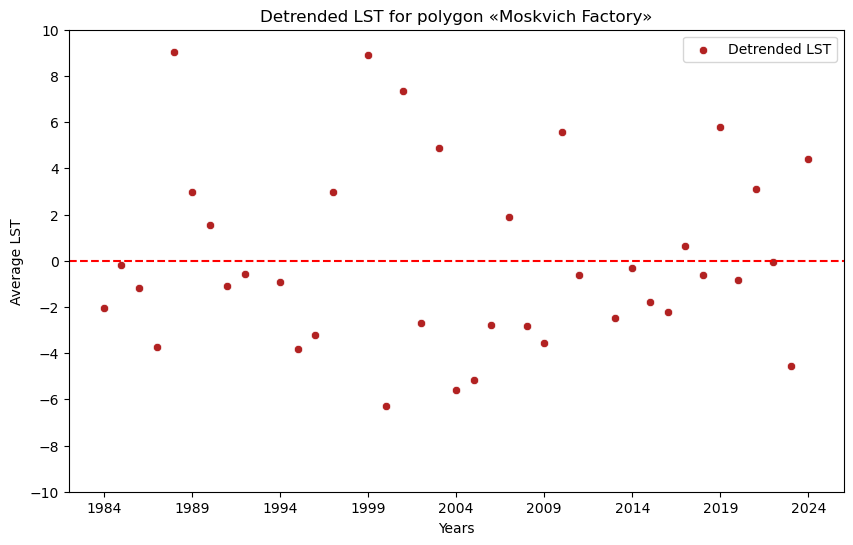

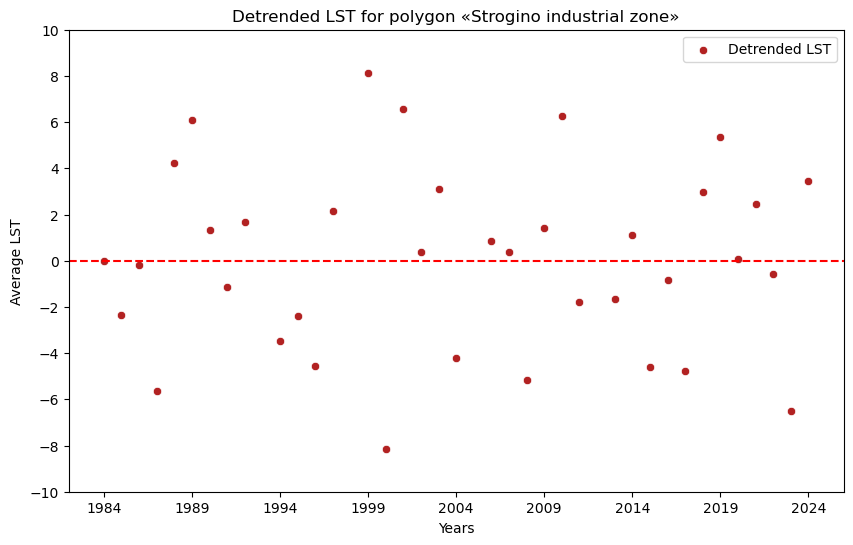

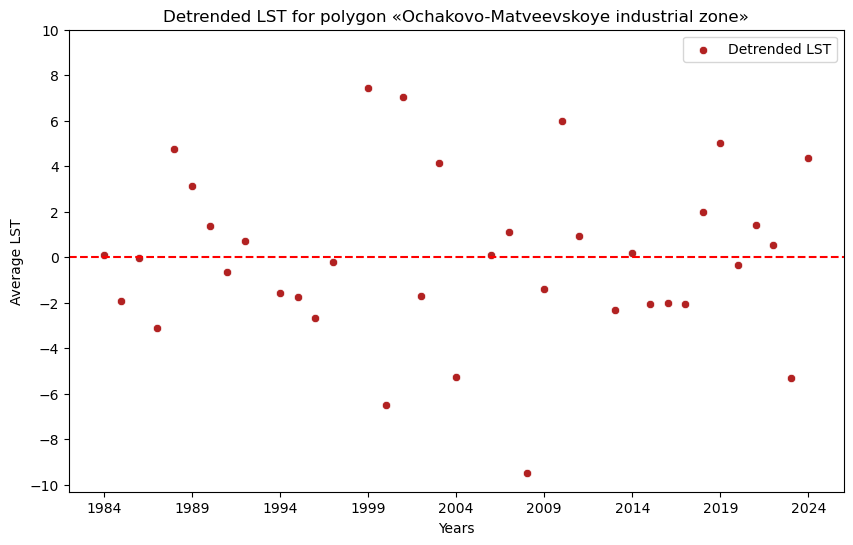

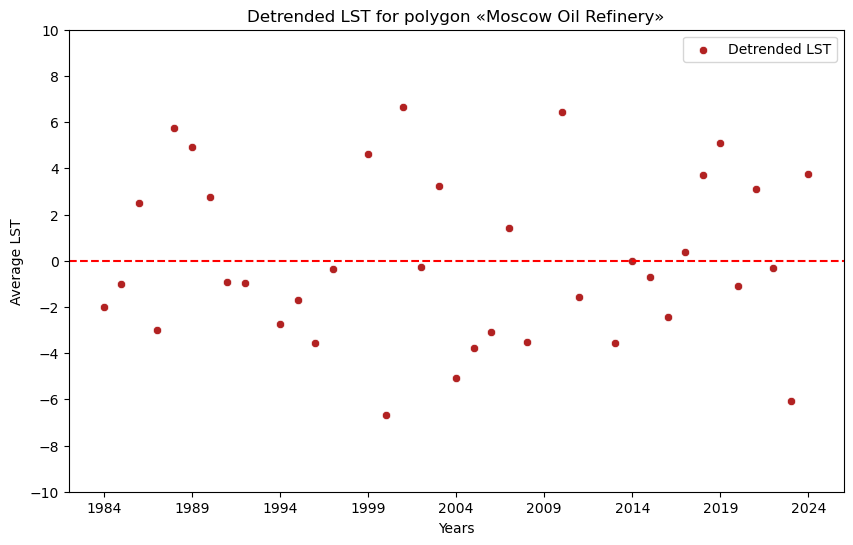

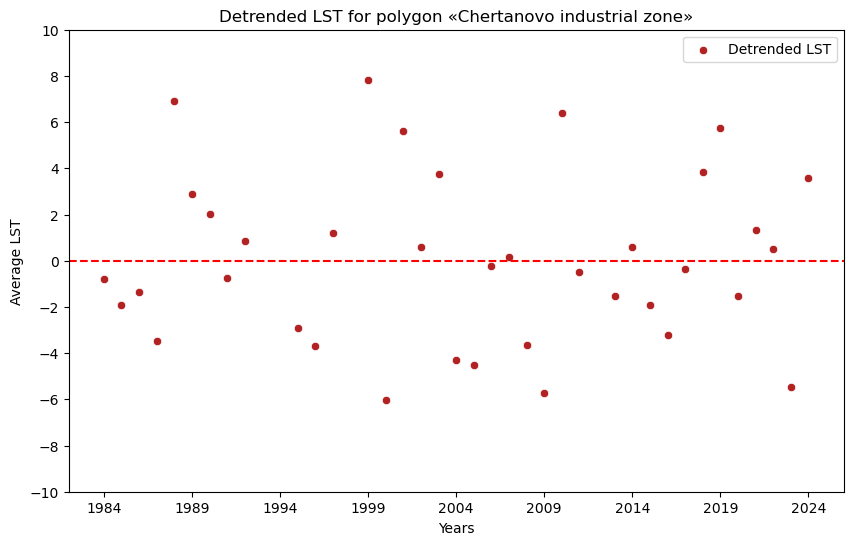

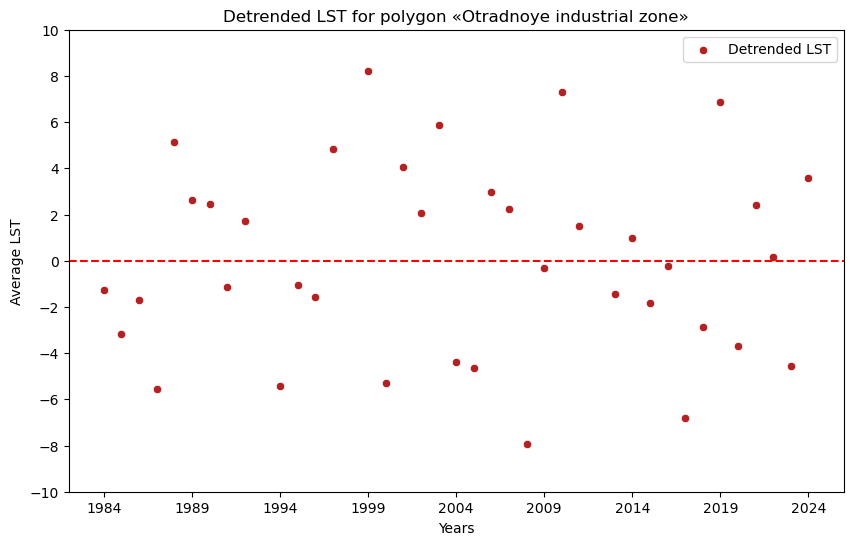

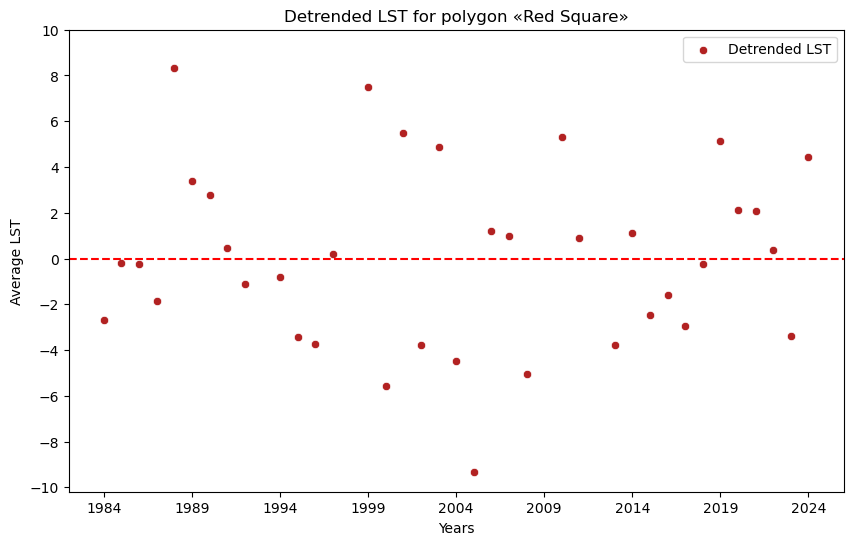

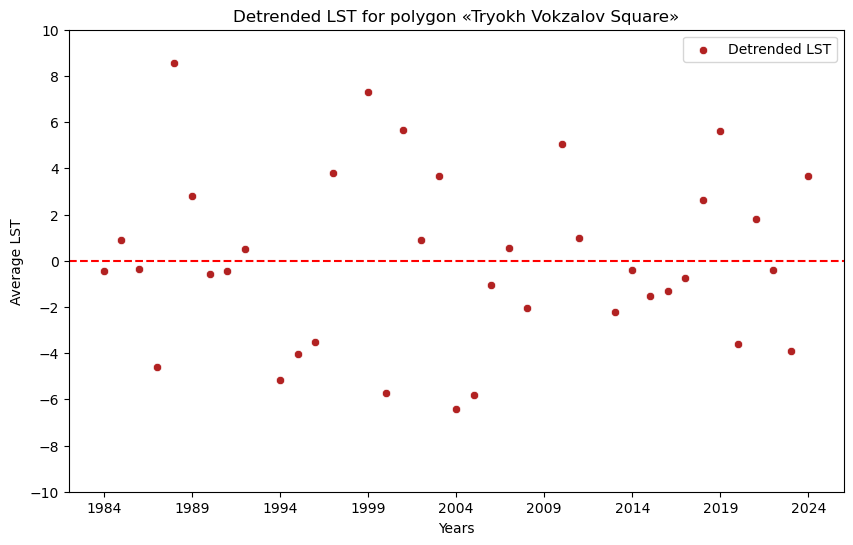

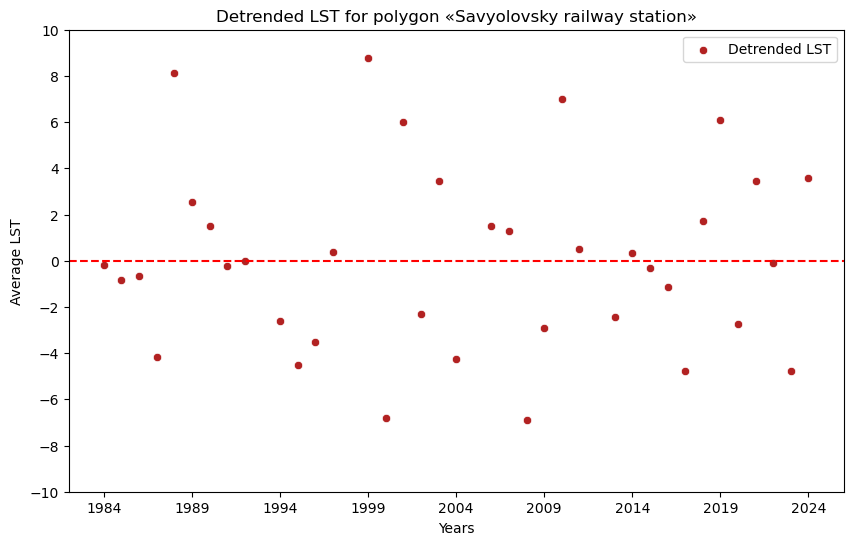

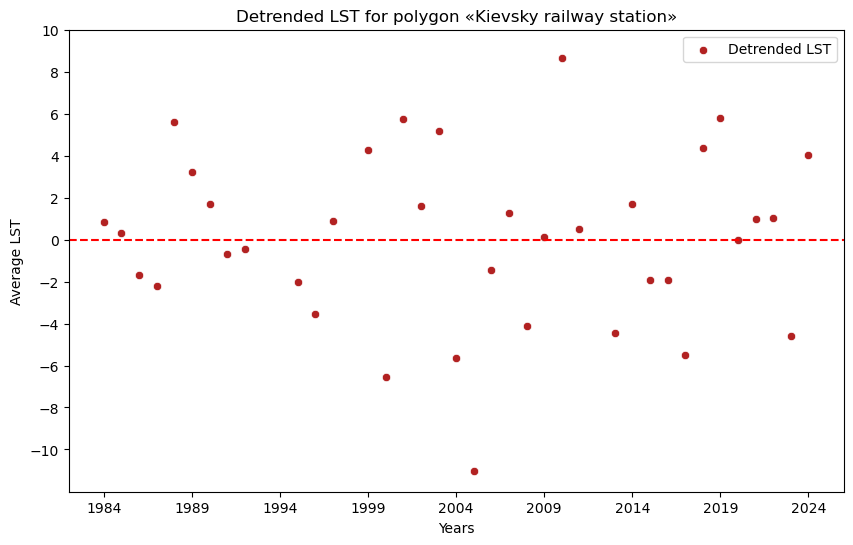

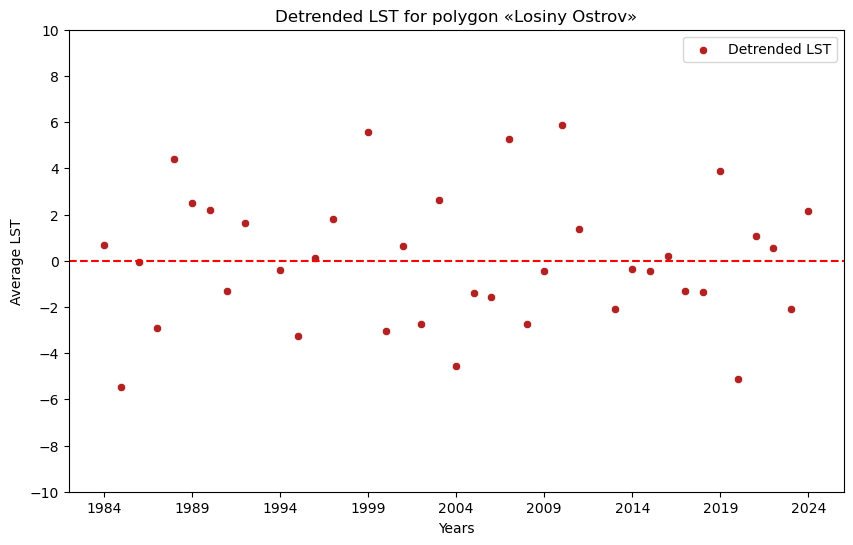

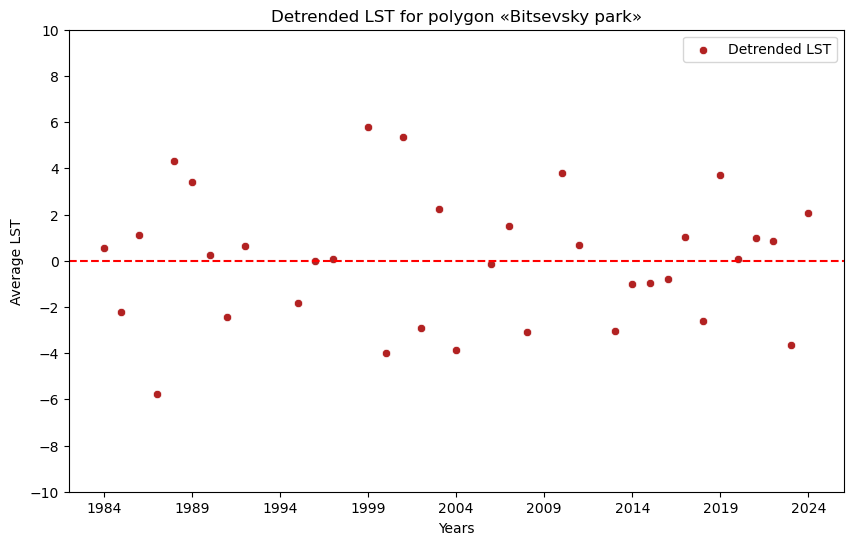

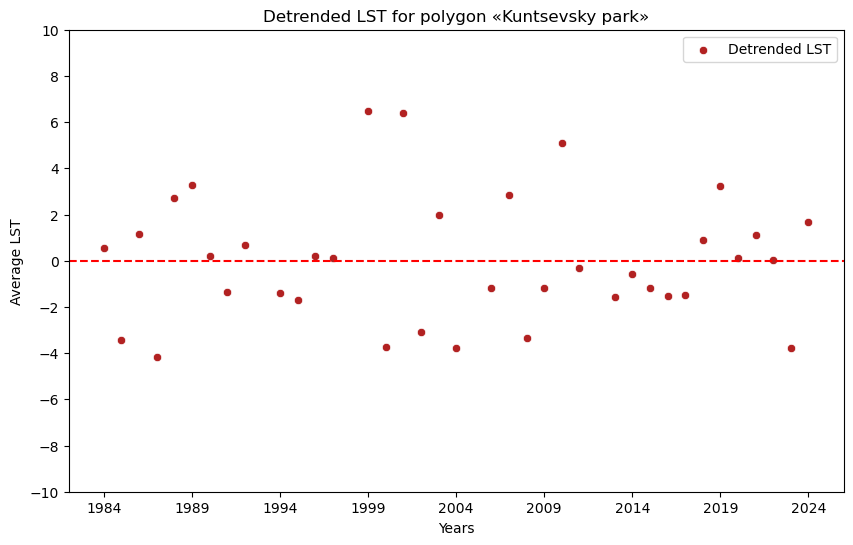

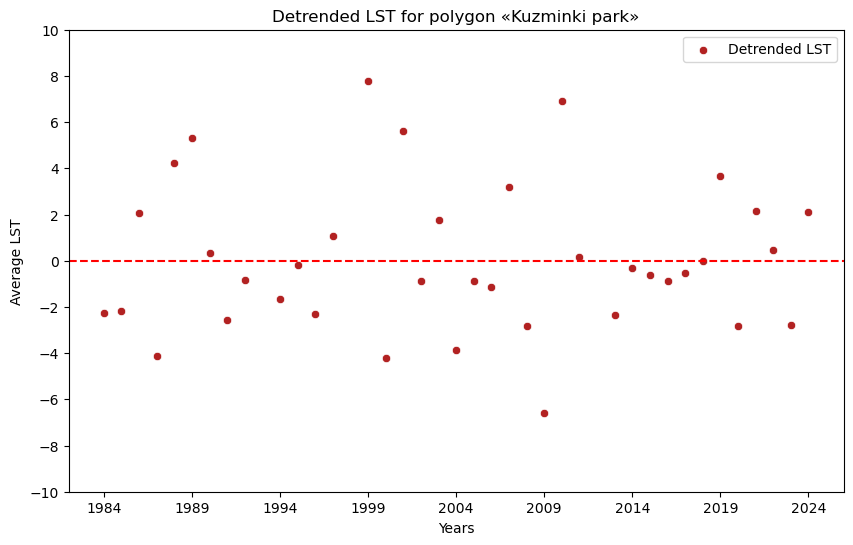

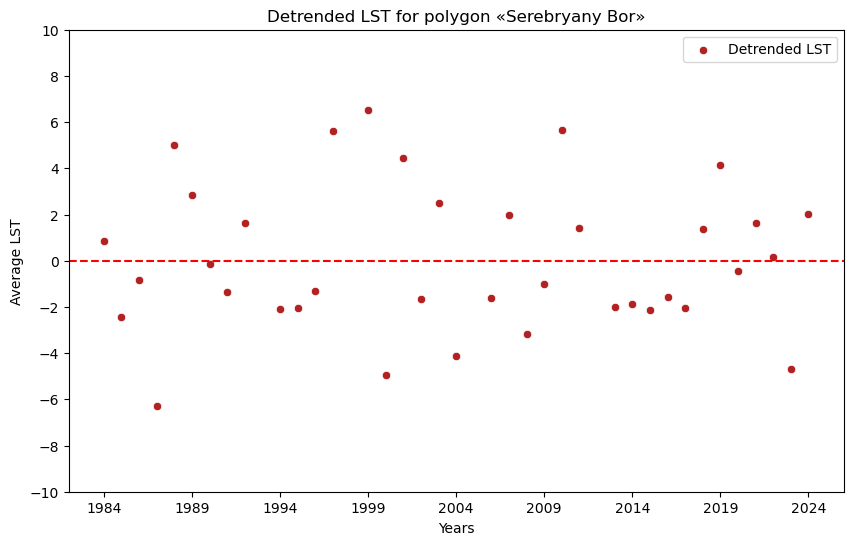

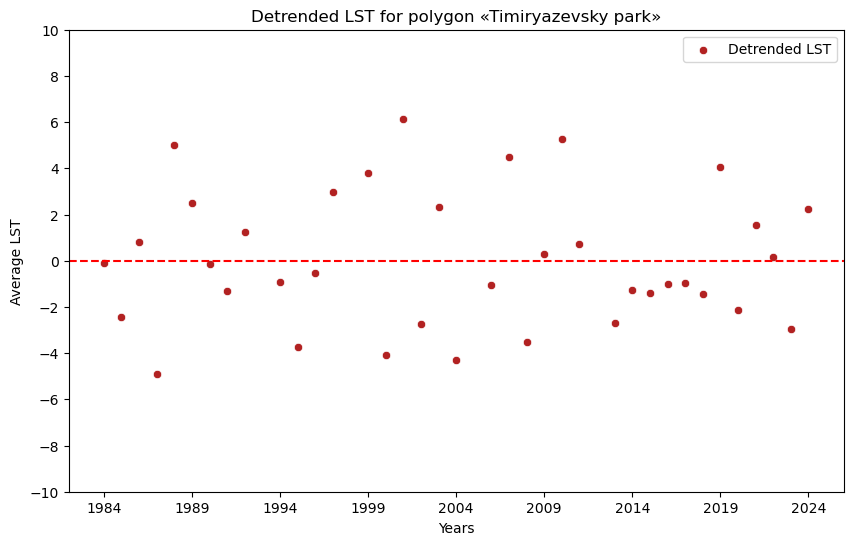

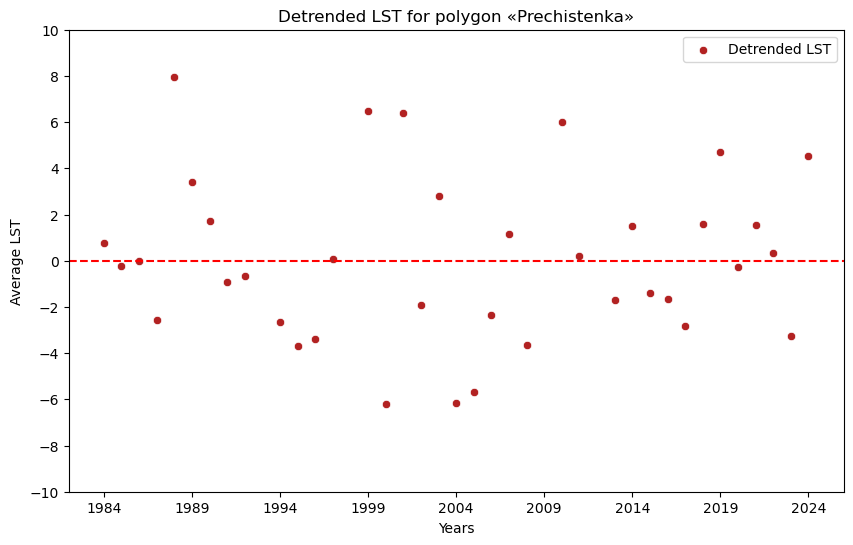

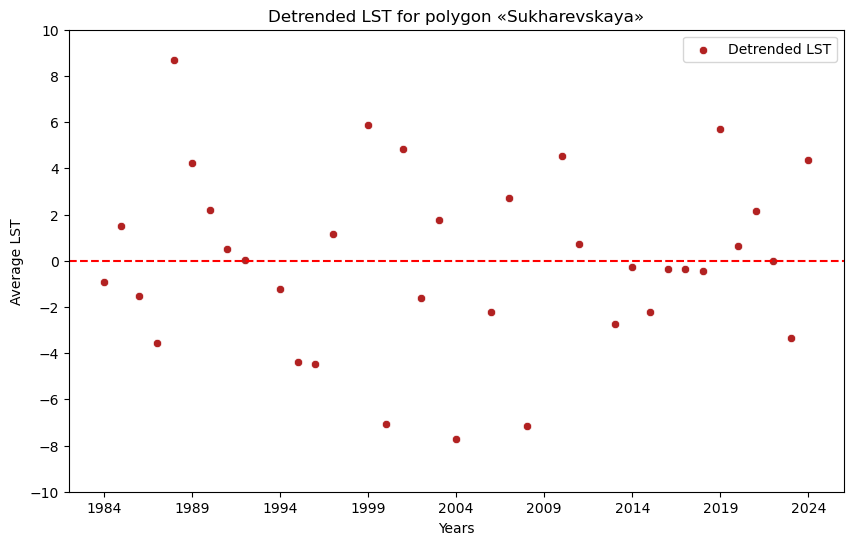

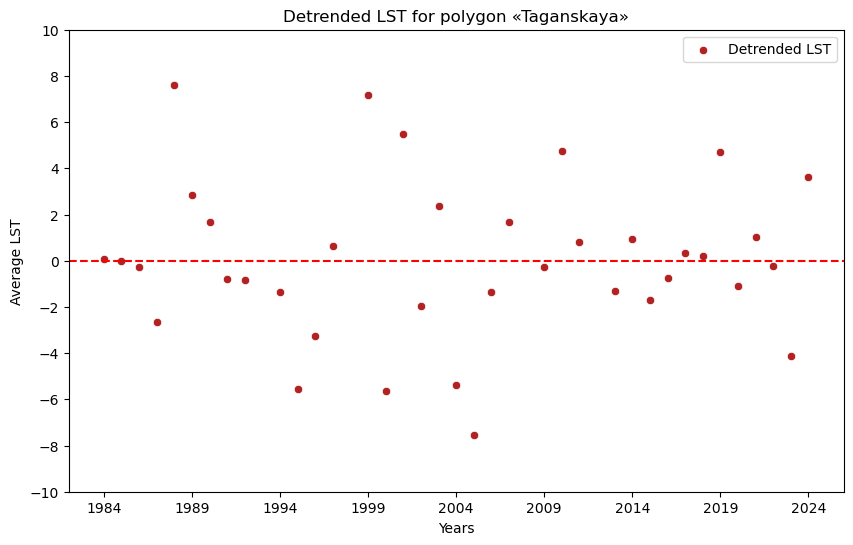

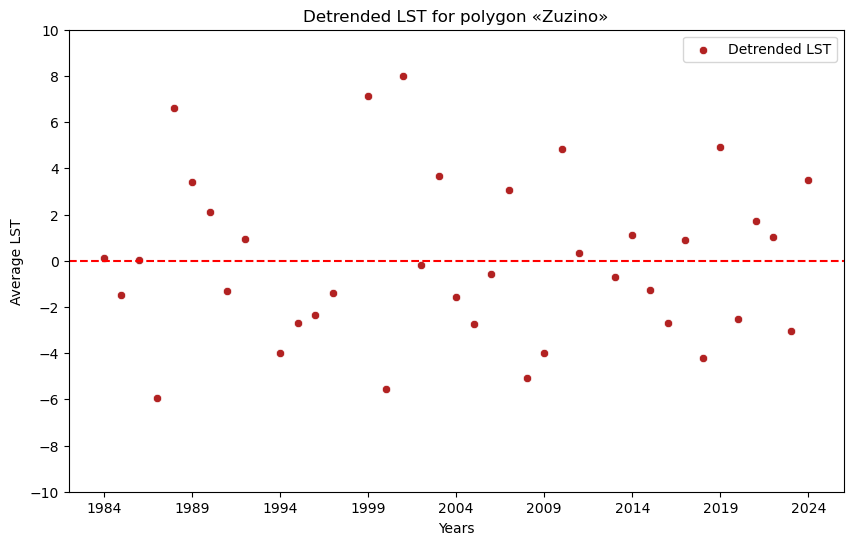

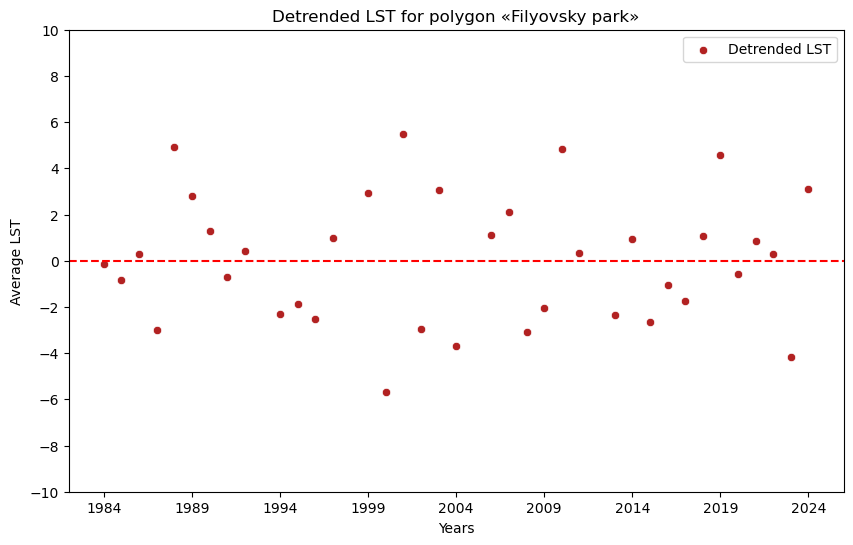

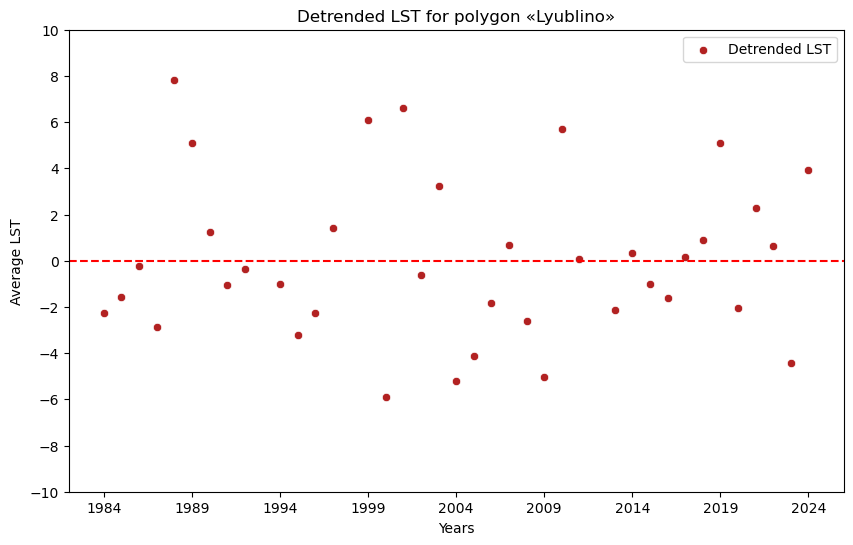

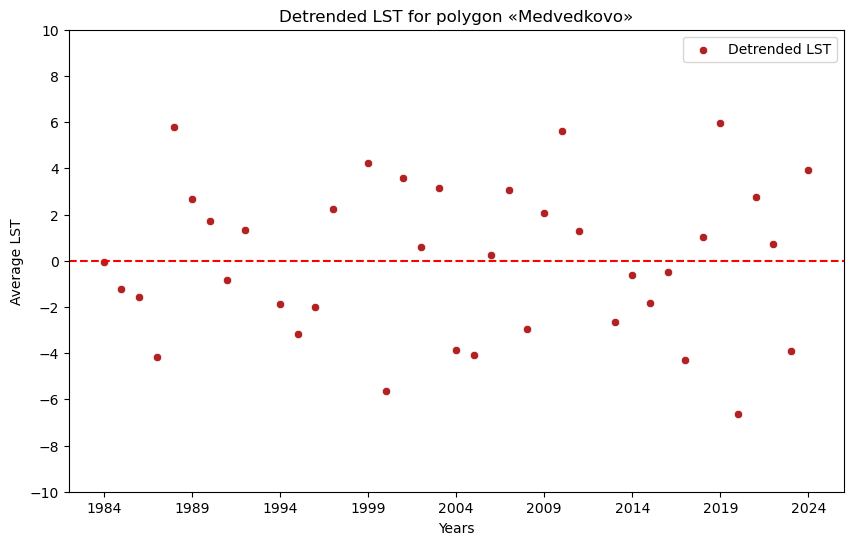

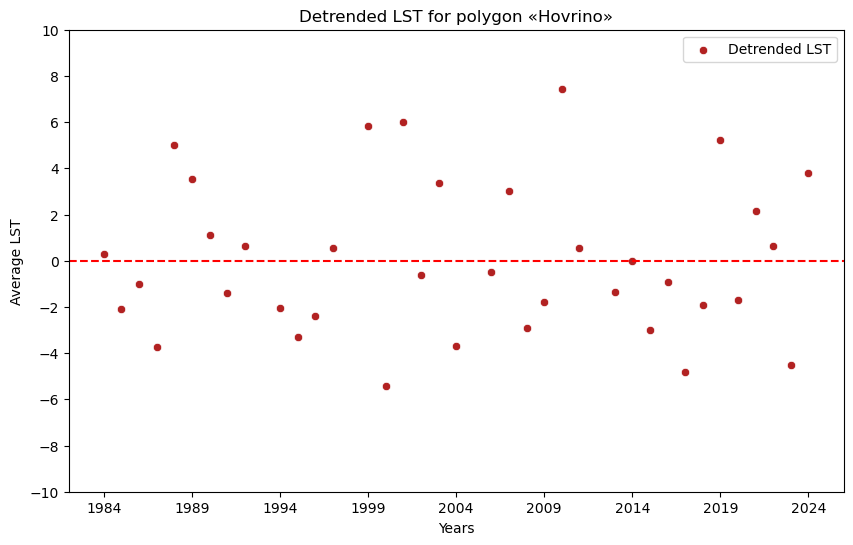

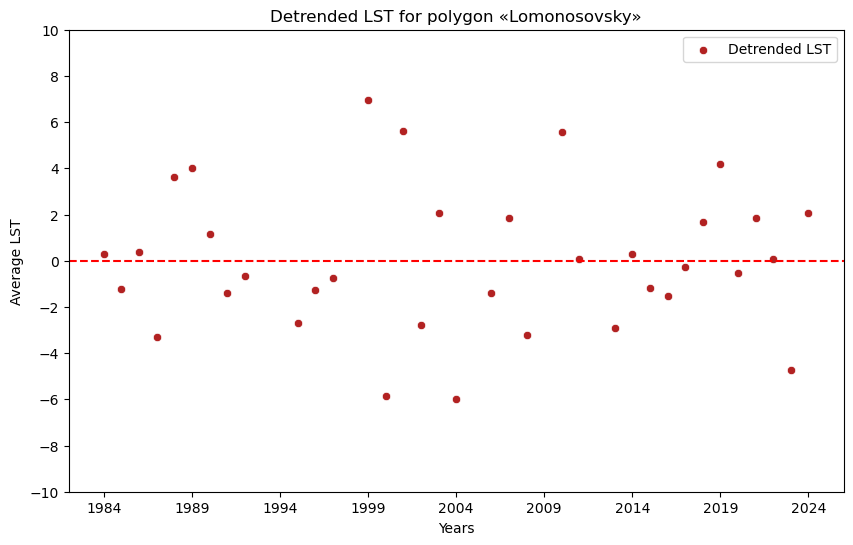

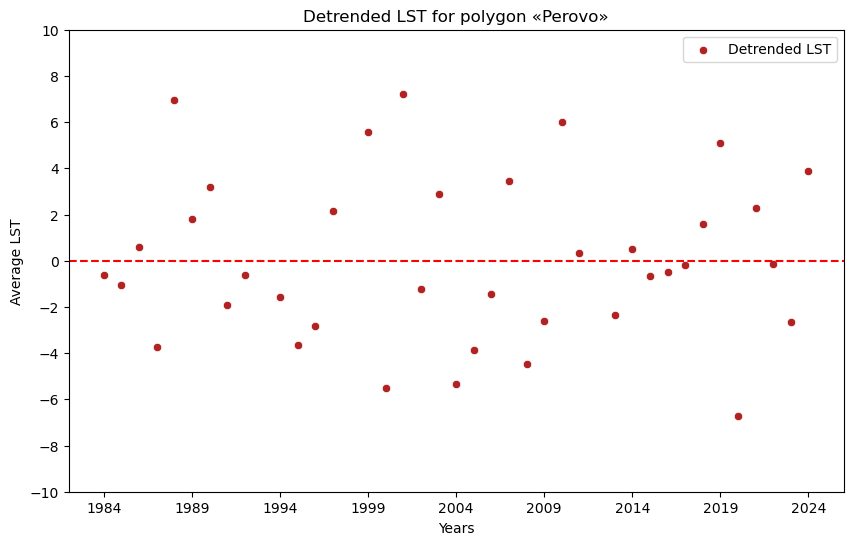

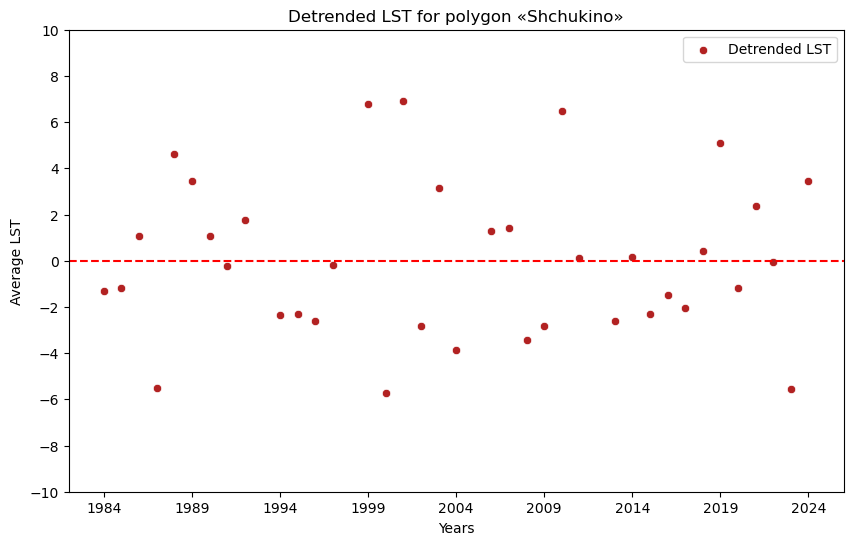

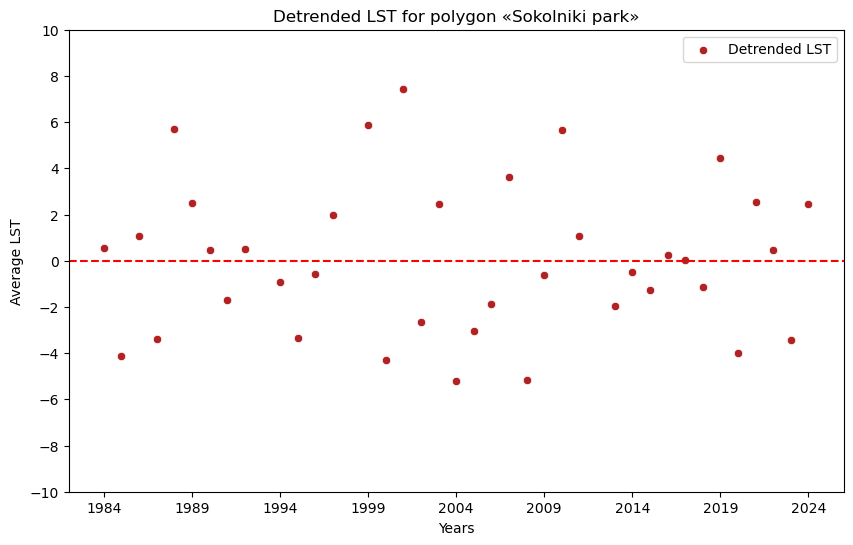

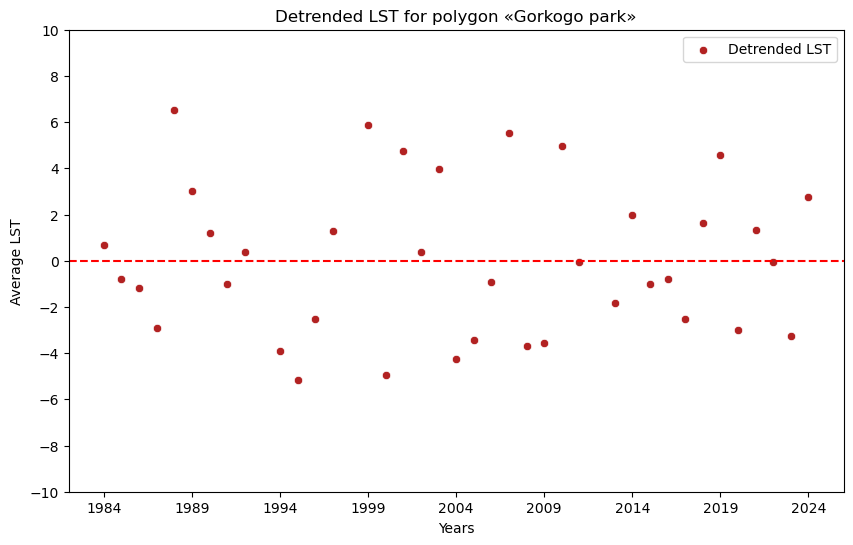

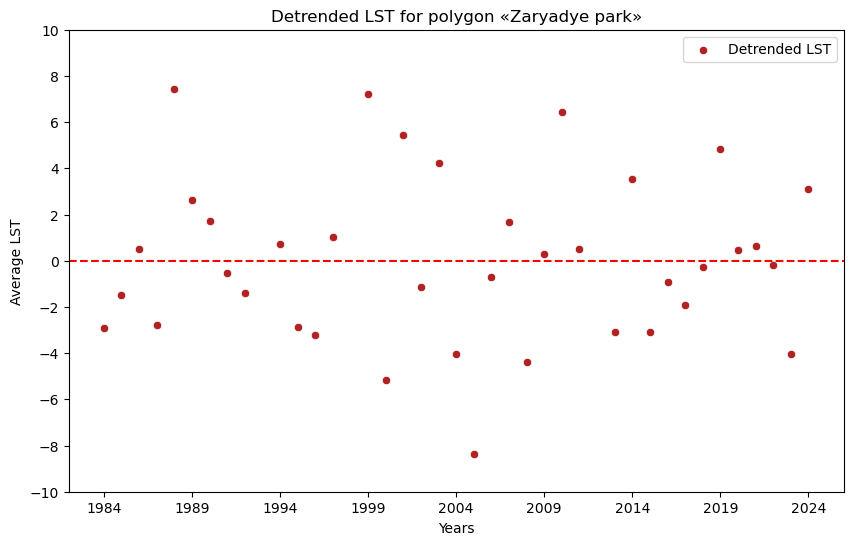

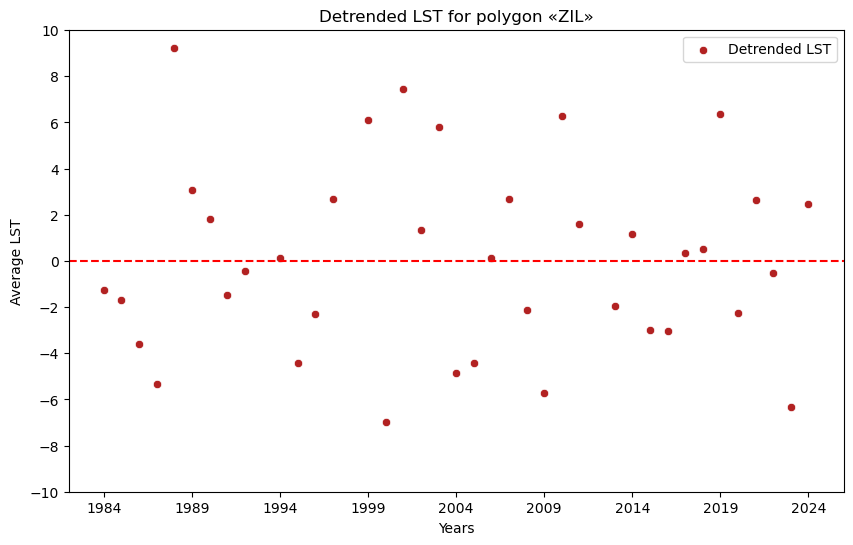

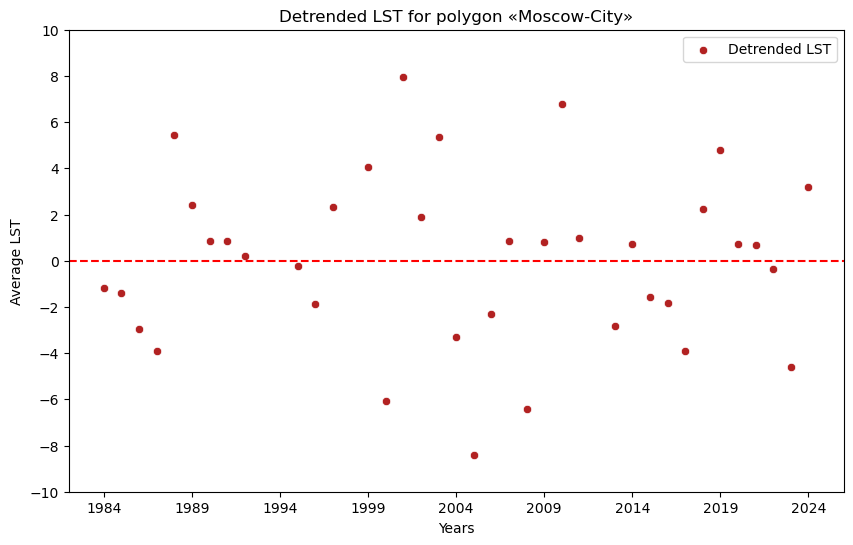

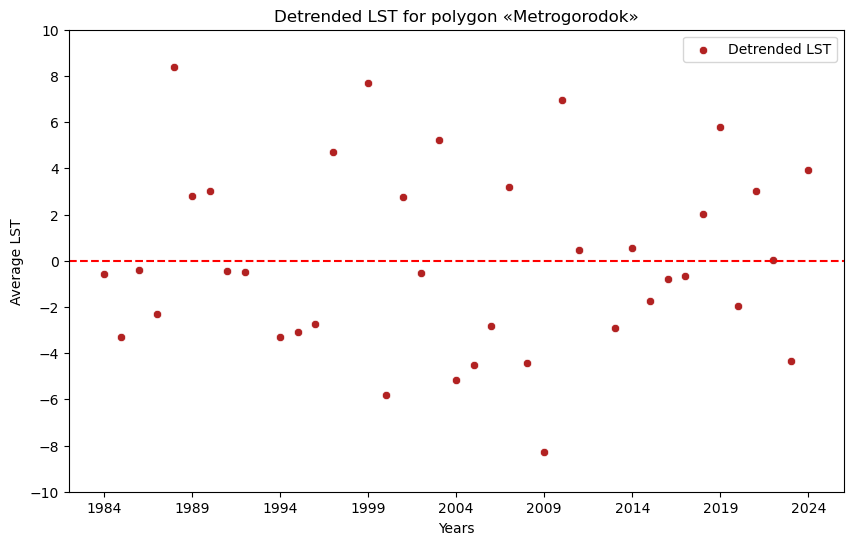

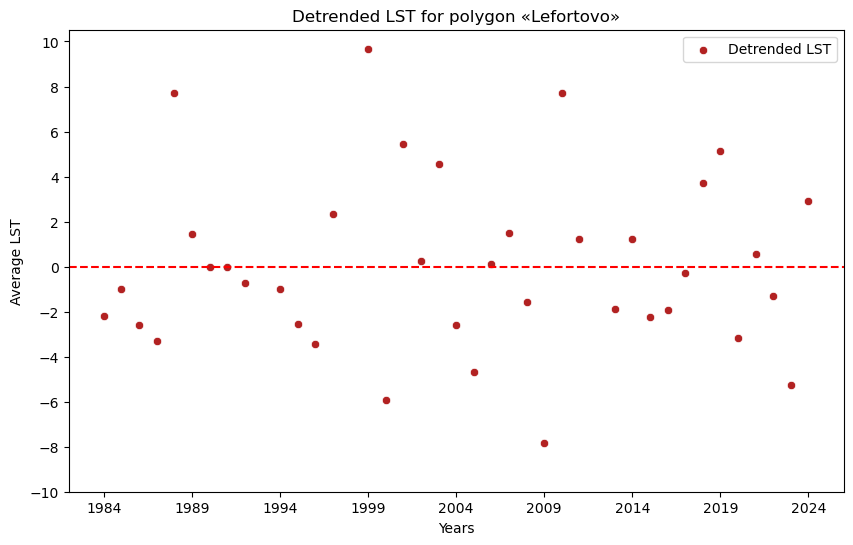

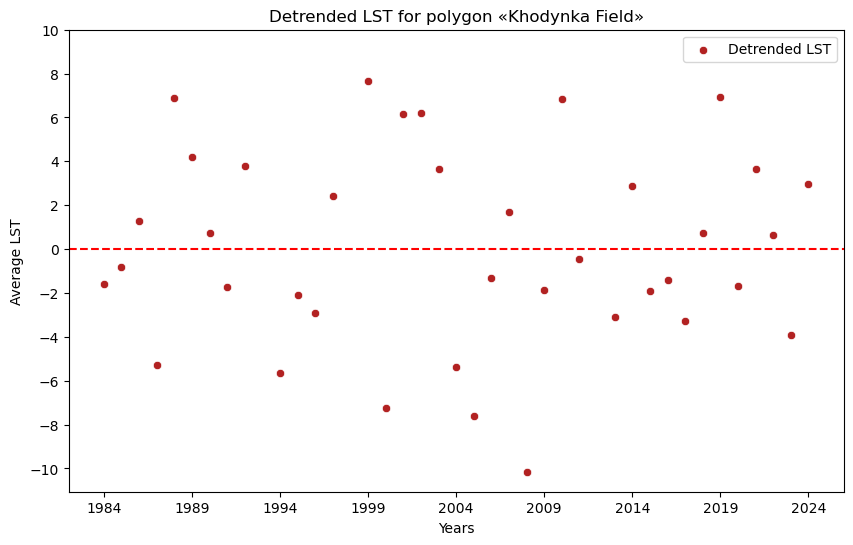

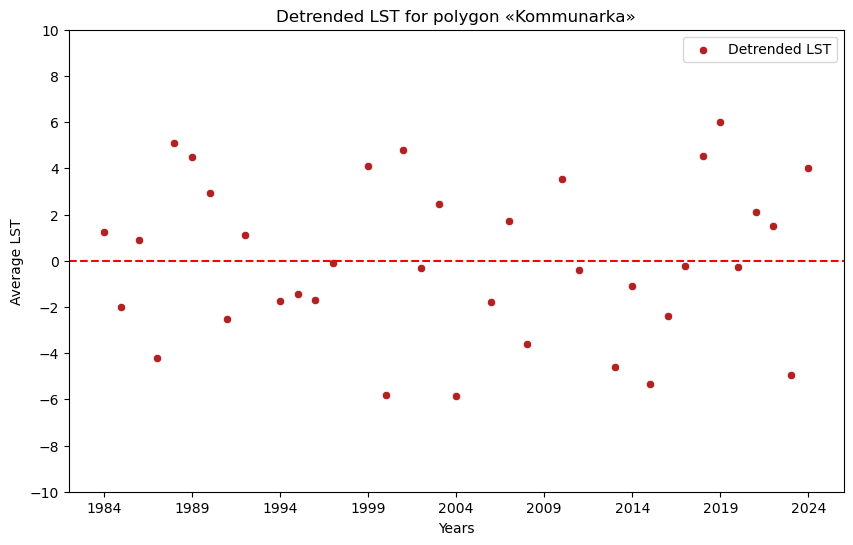

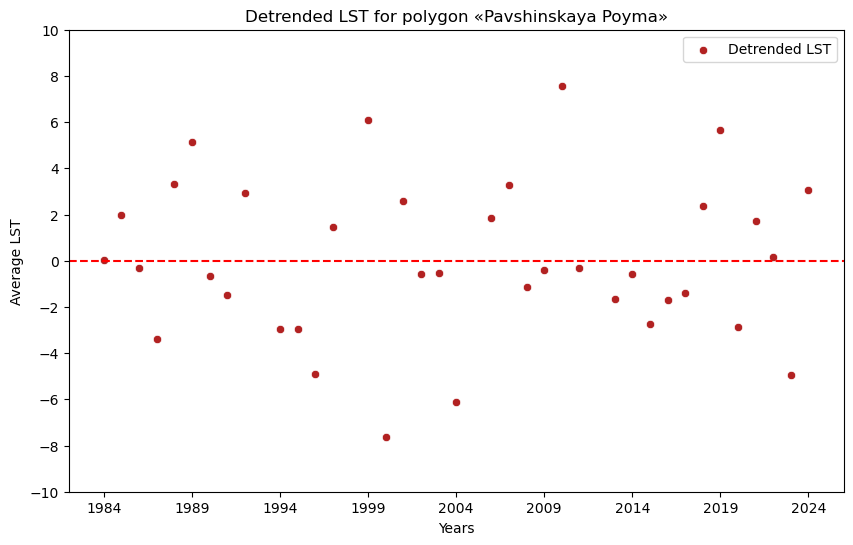

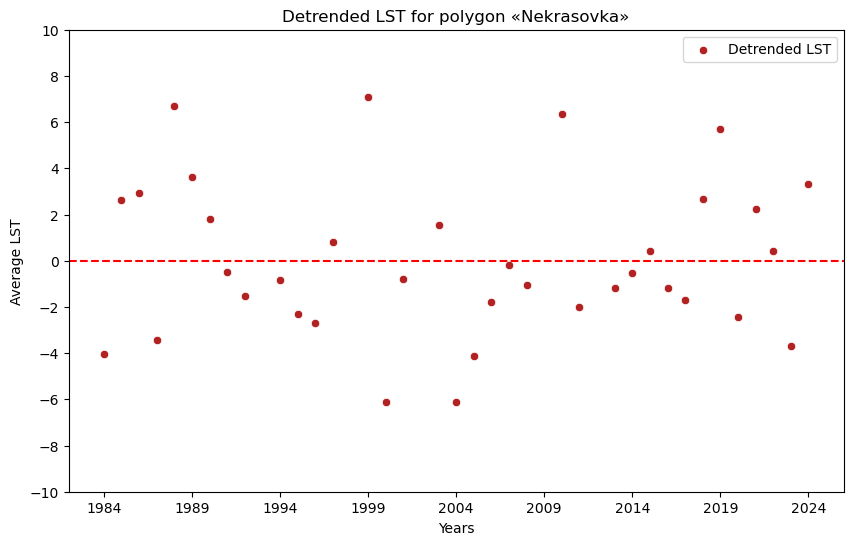

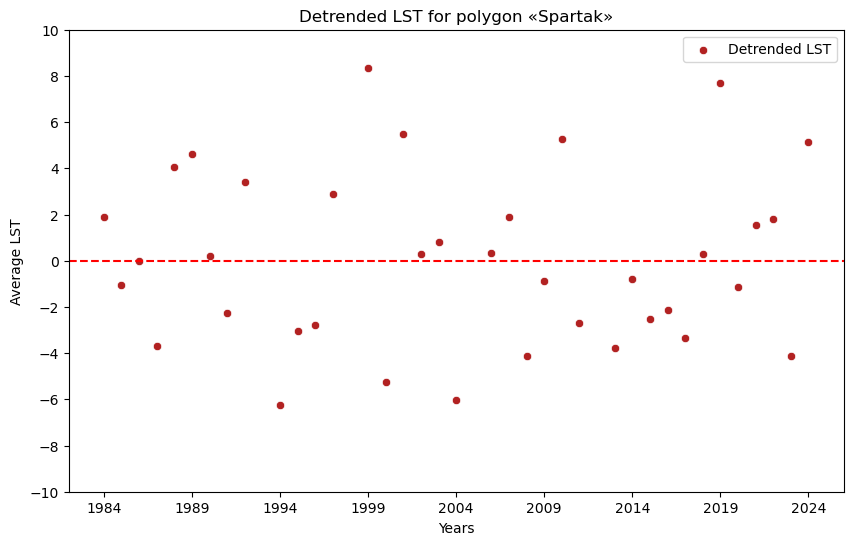

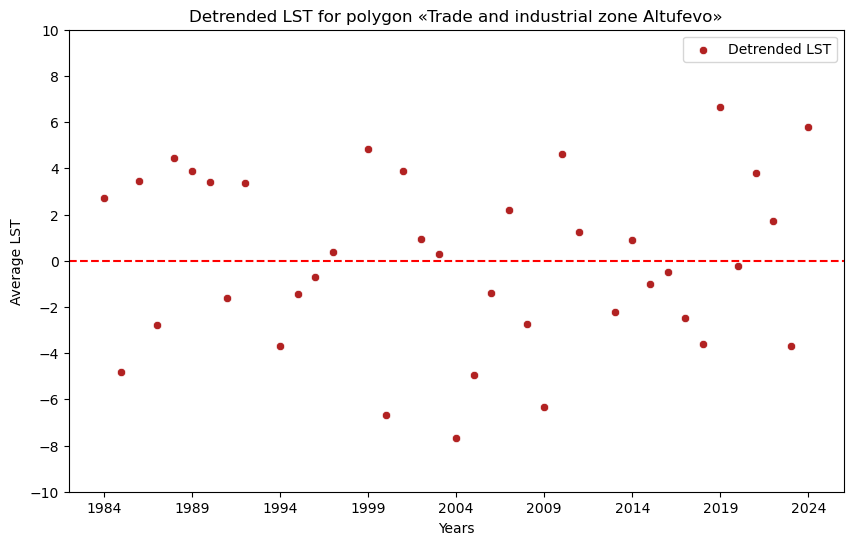

In [ ]:
# Cycle for each polygon
for ID in polygons_id:

    ts_poly_df_clean = df_clean.loc[ID]

    # Get polygon data (year + LST)
    x = ts_poly_df_clean['year']
    years_ticks = np.arange(x.min(), x.max()+1, 5)
    y = ts_poly_df_clean['mean_LST']

    lcz_name = ts_poly_df_clean['en_name'].iloc[0]

    # Detrend time series (delete linear trend)
    y_detrended = signal.detrend(y, type='linear')

    # Visualize detrended data
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y_detrended, color='firebrick', label='Detrended Data')

    plt.axhline(0, color='red', ls='--')

    plt.xlabel('Years')
    plt.ylabel('Average LST')
    title = plt.title(f'Detrended LST for polygon «{lcz_name}»')
    plt.legend(['Detrended LST'])
    plt.xticks(years_ticks)
    plt.yticks(np.arange(-10,11, 2))

    # Save graph
    # plt.savefig(f'D:\Kursach_2\comps\plots\detrended\{title}.png', bbox_inches='tight')
    plt.show()


# View trend by class

In [ ]:
df_clean = df.dropna(subset=['mean_LST'])

In [ ]:
classes = df_clean['lcz'].unique()

In [ ]:
classes

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [ ]:
df_clean = df_clean.reset_index()
df_clean = df_clean.sort_values('lcz')
df_clean = df_clean.set_index('lcz')

In [ ]:
df_clean

index  lcz_id            lcz_name   mean_BU   mean_LST  mean_NDBI  \
lcz                                                                      
1        0      11            moscvich -0.273184  28.987634  -0.094475   
1      145      14         neft_moscow -0.174326  36.866835  -0.024517   
1      146      14         neft_moscow -0.164091  38.390080   0.009166   
1      147      14         neft_moscow -0.222231  32.338871  -0.073896   
1      148      14         neft_moscow -0.134864  36.655693   0.011754   
..     ...     ...                 ...       ...        ...        ...   
8     1371      83  pavshinskaya_poyma -0.711548  21.933764  -0.254613   
8     1372      83  pavshinskaya_poyma -0.795980  28.848171  -0.280431   
8     1373      83  pavshinskaya_poyma -0.581324  30.926988  -0.161283   
8     1361      82          kommunarka -0.602723  33.494963  -0.176106   
8     1519      86             severny -0.338018  41.006480  -0.091853   

                                en_name  year              classname  
lcz                                                                   
1                      Moskvich Factory  1984       Industrial areas  
1                   Moscow Oil Refinery  2018       Industrial areas  
1                   Moscow Oil Refinery  2019       Industrial areas  
1                   Moscow Oil Refinery  2020       Industrial areas  
1                   Moscow Oil Refinery  2021       Industrial areas  
..                                  ...   ...                    ...  
8                    Pavshinskaya Poyma  1987  New development areas  
8                    Pavshinskaya Poyma  1988  New development areas  
8                    Pavshinskaya Poyma  1989  New development areas  
8                            Kommunarka  2018  New development areas  
8    Trade and industrial zone Altufevo  2024  New development areas  

[1489 rows x 9 columns]

### Construct similar plots of time trends by polygon classes

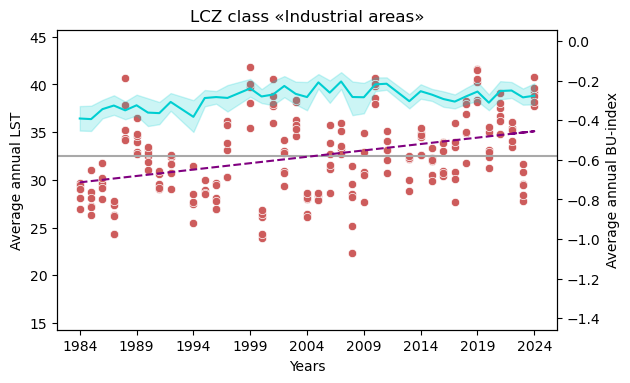

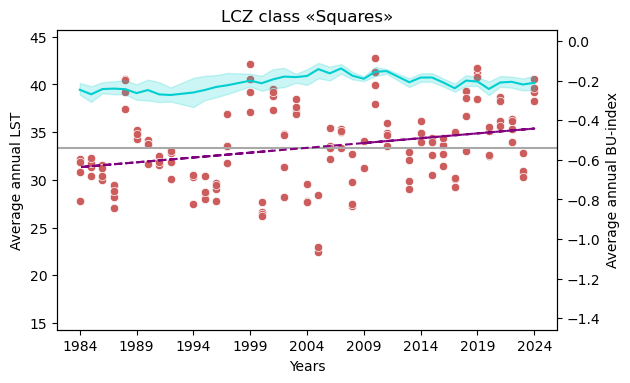

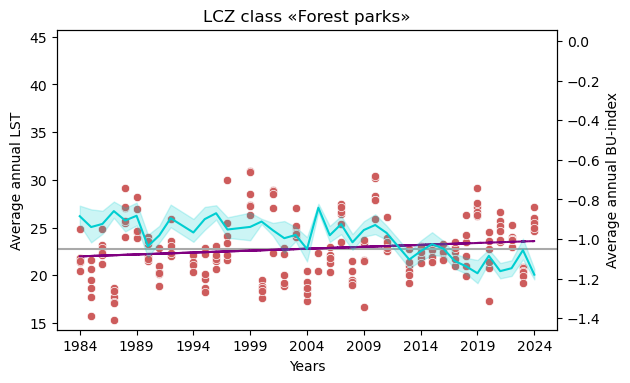

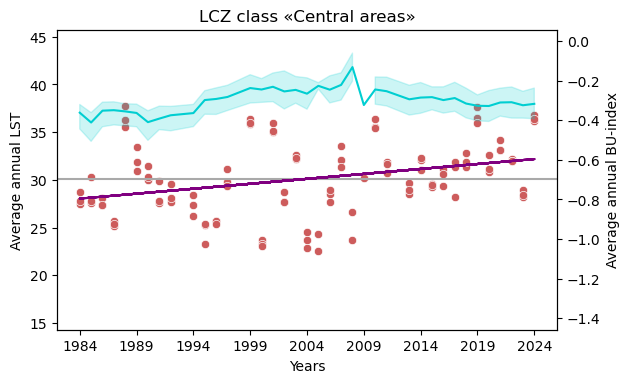

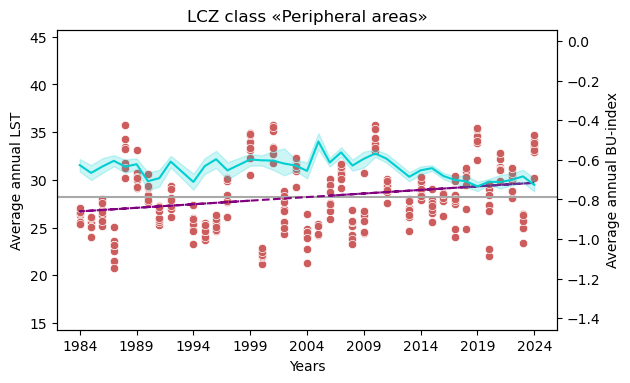

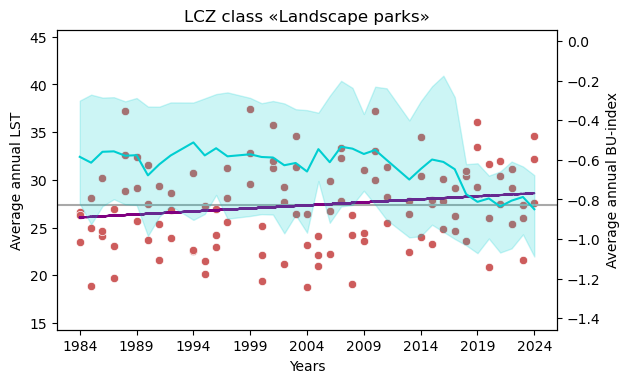

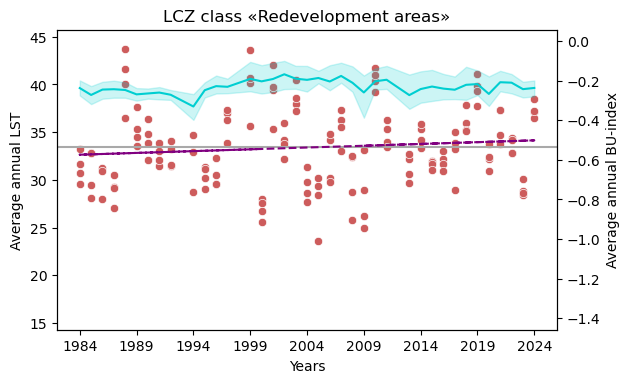

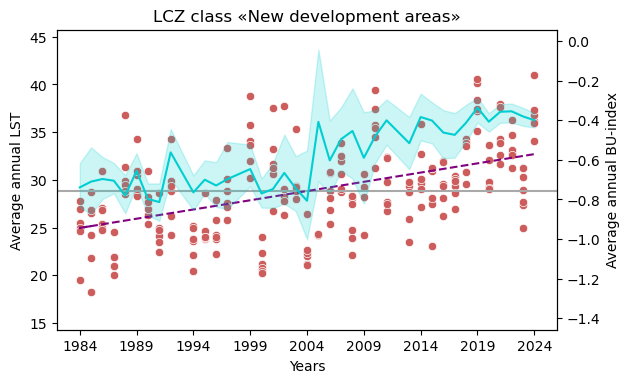

In [ ]:
for class_num in classes:

    ts_class_df_clean = df_clean.loc[class_num]

    x = ts_class_df_clean['year']
    years_ticks = np.arange(x.min(), x.max()+1, 5)

    y = ts_class_df_clean['mean_LST']
    ymin = df_clean['mean_LST'].min() - 1
    ymax = df_clean['mean_LST'].max() + 2

    y2 = ts_class_df_clean['mean_BU']
    y2min = df_clean['mean_BU'].min() - 0.2
    y2max = df_clean['mean_BU'].max() + 0.1

    fig = plt.figure(figsize=(5,3))
    ax1 = fig.add_axes([0,0,1,1])
    ax1.set_ylim(ymin, ymax)
    sns.scatterplot(x=x, y=y, ax=ax1, color='indianred')
    ax1.axhline(y.mean(), color='darkgrey')
    #plt.axhline(ts_poly_df_clean['mean_LST'].median(), color='purple')

    # Plot linear trend
    coeffs = np.polyfit(x, y, 1)
    polynomial = np.poly1d(coeffs)
    ax1.plot(x, polynomial(x), color='purple', ls='--')
    ax1.set_xlabel('Years')
    ax1.set_ylabel('Average annual LST')
    ax1.set_xticks(years_ticks)

    ax2 = ax1.twinx()
    ax2.set_ylim(y2min,y2max)
    ax2.set_ylabel('Average annual BU-index')
    sns.lineplot(x=x, y=y2, ax=ax2, color='darkturquoise')

    title = plt.title("LCZ class «"+ts_class_df_clean['classname'].iloc[0]+'»')
    plt.savefig(rf"D:\Kursach_2\newpics\{title}.png", bbox_inches='tight')

    plt.show()

### Statistical significance check-up

In [ ]:
df_clean

index  lcz_id            lcz_name   mean_BU   mean_LST  mean_NDBI  \
lcz                                                                      
1        0      11            moscvich -0.273184  28.987634  -0.094475   
1      145      14         neft_moscow -0.174326  36.866835  -0.024517   
1      146      14         neft_moscow -0.164091  38.390080   0.009166   
1      147      14         neft_moscow -0.222231  32.338871  -0.073896   
1      148      14         neft_moscow -0.134864  36.655693   0.011754   
..     ...     ...                 ...       ...        ...        ...   
8     1371      83  pavshinskaya_poyma -0.711548  21.933764  -0.254613   
8     1372      83  pavshinskaya_poyma -0.795980  28.848171  -0.280431   
8     1373      83  pavshinskaya_poyma -0.581324  30.926988  -0.161283   
8     1361      82          kommunarka -0.602723  33.494963  -0.176106   
8     1519      86             severny -0.338018  41.006480  -0.091853   

                                en_name  year              classname  
lcz                                                                   
1                      Moskvich Factory  1984       Industrial areas  
1                   Moscow Oil Refinery  2018       Industrial areas  
1                   Moscow Oil Refinery  2019       Industrial areas  
1                   Moscow Oil Refinery  2020       Industrial areas  
1                   Moscow Oil Refinery  2021       Industrial areas  
..                                  ...   ...                    ...  
8                    Pavshinskaya Poyma  1987  New development areas  
8                    Pavshinskaya Poyma  1988  New development areas  
8                    Pavshinskaya Poyma  1989  New development areas  
8                            Kommunarka  2018  New development areas  
8    Trade and industrial zone Altufevo  2024  New development areas  

[1489 rows x 9 columns]

In [ ]:
results_class = []

for class_num in classes:
    # Filter by class
    ts_class_df_clean = df_clean.loc[class_num]

    x = ts_class_df_clean['year'].values
    y = ts_class_df_clean['mean_LST'].values

    # Linear regression
    slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

    # Save a result
    results_class.append({
        'lcz_class': class_num,
        'classname': ts_class_df_clean['classname'].iloc[0],
        'n_points': len(ts_class_df_clean),
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value,
        'p_value': p_value,
        'std_err': std_err
    })

# To DataFrame
results_class_df = pd.DataFrame(results_class)

In [ ]:
results_class_df.sort_values('lcz_class')

# Temperature trend statistics by class

lcz_class              classname  n_points     slope   intercept   r_value  \
0          1       Industrial areas       224  0.133947 -236.019176  0.386917   
1          2                Squares       148  0.101118 -169.290489  0.297494   
2          3           Forest parks       222  0.040040  -57.463339  0.157751   
3          4          Central areas       110  0.103641 -177.594671  0.336920   
4          5       Peripheral areas       298  0.074936 -121.982970  0.264420   
5          6        Landscape parks       114  0.063456  -99.843392  0.176713   
6          7    Redevelopment areas       151  0.037593  -41.954161  0.113037   
7          8  New development areas       222  0.193433 -358.816650  0.505657   

        p_value   std_err  
0  2.053487e-09  0.021425  
1  2.406831e-04  0.026857  
2  1.867735e-02  0.016898  
3  3.193103e-04  0.027869  
4  3.691335e-06  0.015886  
5  5.999730e-02  0.033397  
6  1.669980e-01  0.027071  
7  8.201009e-16  0.022251

In [ ]:
results_class_df[results_class_df['p_value']<0.05]

# Statistically significant classes at significance level 0.05

lcz_class              classname  n_points     slope   intercept   r_value  \
0          1       Industrial areas       224  0.133947 -236.019176  0.386917   
1          2                Squares       148  0.101118 -169.290489  0.297494   
2          3           Forest parks       222  0.040040  -57.463339  0.157751   
3          4          Central areas       110  0.103641 -177.594671  0.336920   
4          5       Peripheral areas       298  0.074936 -121.982970  0.264420   
7          8  New development areas       222  0.193433 -358.816650  0.505657   

        p_value   std_err  
0  2.053487e-09  0.021425  
1  2.406831e-04  0.026857  
2  1.867735e-02  0.016898  
3  3.193103e-04  0.027869  
4  3.691335e-06  0.015886  
7  8.201009e-16  0.022251

In [ ]:
results_class_df[results_class_df['p_value']>0.05]

# Statistically unsignificant classes at significance level 0.05

lcz_class            classname  n_points     slope  intercept   r_value  \
5          6      Landscape parks       114  0.063456 -99.843392  0.176713   
6          7  Redevelopment areas       151  0.037593 -41.954161  0.113037   

    p_value   std_err  
5  0.059997  0.033397  
6  0.166998  0.027071

Class detrending using scipy.detrend

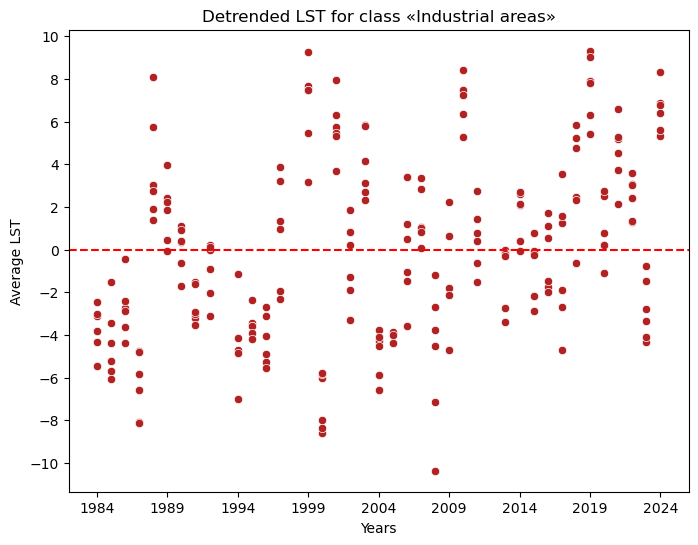

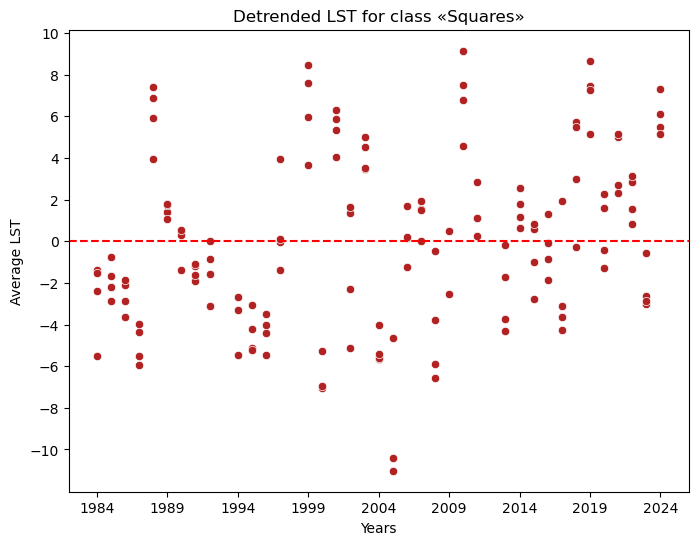

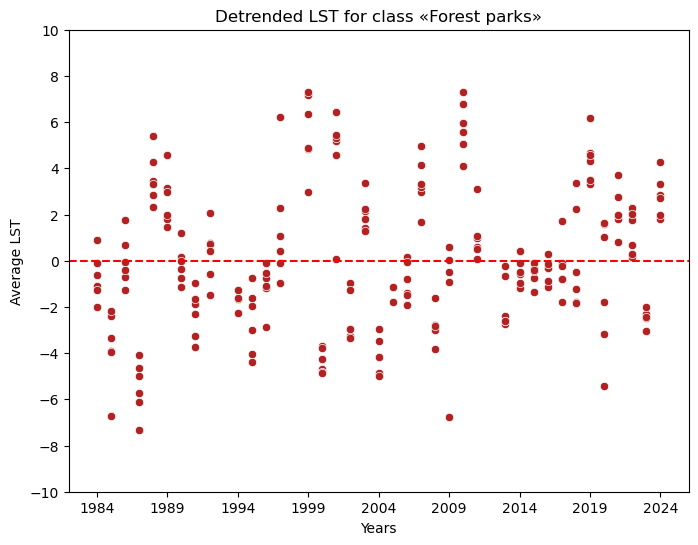

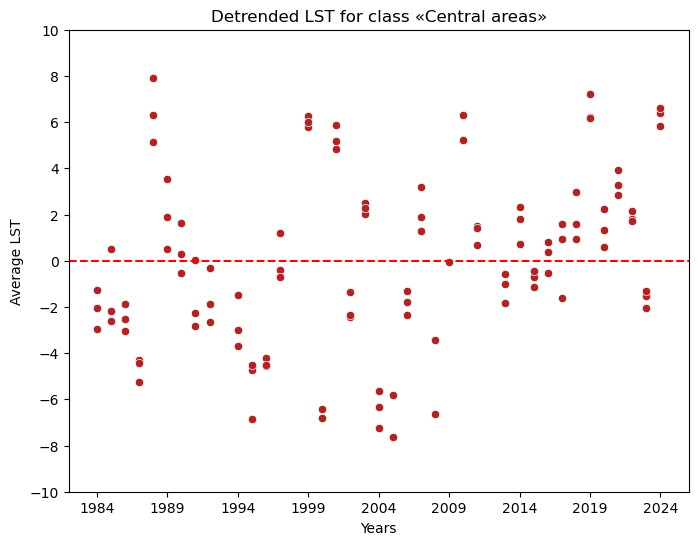

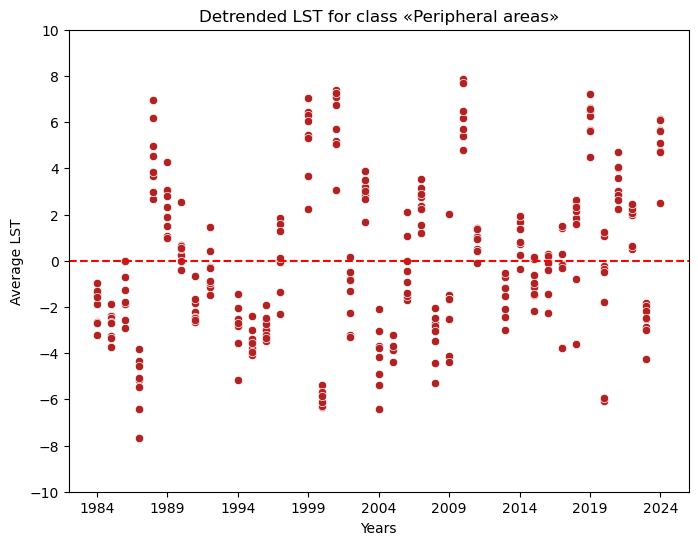

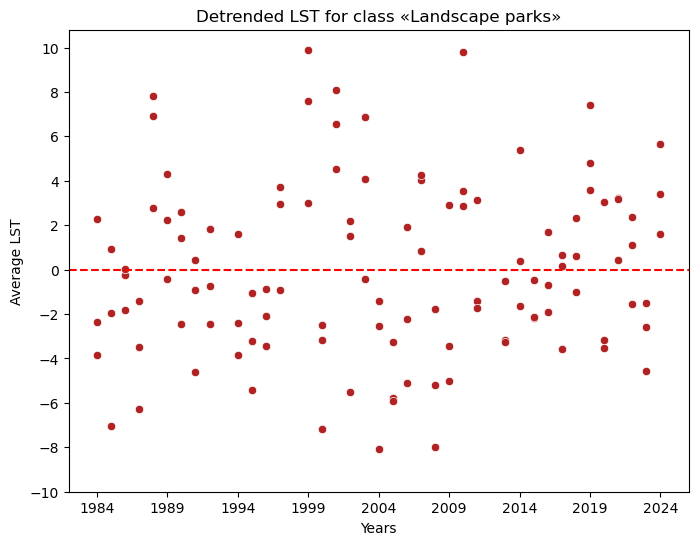

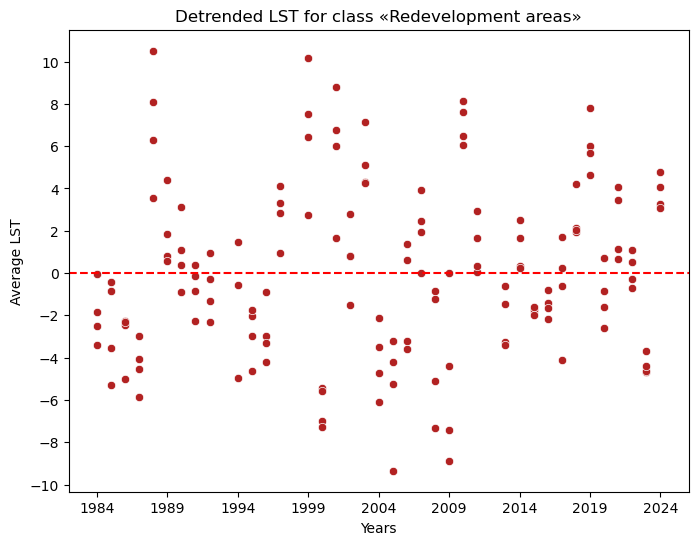

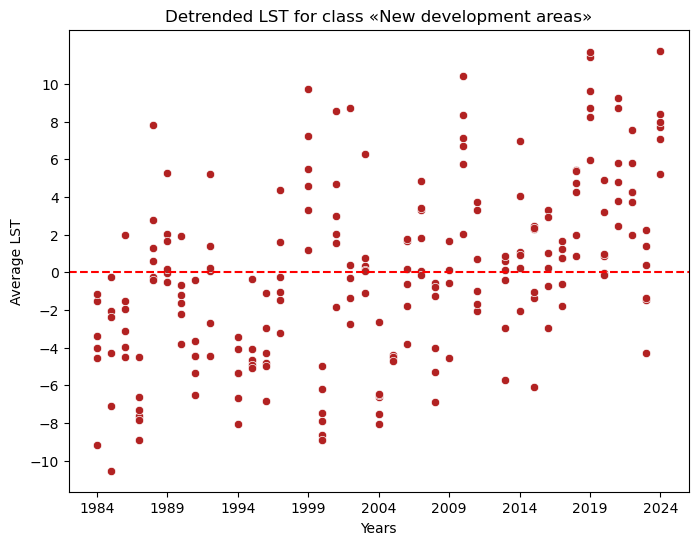

In [ ]:
# For each class
for class_num in classes:

    ts_class_df_clean = df_clean.loc[class_num]

    # Get class data (year + LST)
    x = ts_class_df_clean['year']
    years_ticks = np.arange(x.min(), x.max()+1, 5)
    y = ts_class_df_clean['mean_LST']

    lcz_class = ts_class_df_clean['classname'].iloc[0]

    # Detrend time series
    y_detrended = signal.detrend(y, type='linear')

    # Visualize detrended data
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    #fig = plt.figure(figsize=(5,3))
    sns.scatterplot(x=x, y=y_detrended, color='firebrick', label='Detrended Data')

    plt.axhline(0, color='red', ls='--')

    plt.xlabel('Years')
    plt.ylabel('Average LST')
    title = plt.title(f'Detrended LST for class «{lcz_class}»')
    plt.xticks(years_ticks)
    plt.yticks(np.arange(-10,11, 2))
    ax.get_legend().remove()

    # Save graph
    # plt.savefig(f'D:\Kursach_2\comps\plots\detrended\{title}.png', bbox_inches='tight')
    plt.show()


# General check-up by class

In [ ]:
results_df[results_df['class'] == 1]

class  lcz_id                               lcz_name  n_points     slope  \
0      1      11                       Moskvich Factory        38  0.130765   
1      1      12               Strogino industrial zone        37  0.162024   
2      1      13  Ochakovo-Matveevskoye industrial zone        37  0.118237   
3      1      14                    Moscow Oil Refinery        37  0.122761   
4      1      15             Chertanovo industrial zone        37  0.115194   
5      1      16              Otradnoye industrial zone        38  0.152717   

    intercept   r_value   p_value   std_err  
0 -228.365502  0.375792  0.020067  0.053744  
1 -291.936446  0.451539  0.005028  0.054117  
2 -205.631368  0.370808  0.023862  0.050055  
3 -214.558833  0.390669  0.016818  0.048894  
4 -198.080149  0.358904  0.029150  0.050638  
5 -273.592570  0.411191  0.010328  0.056425

In [ ]:
results_df[results_df['class'] == 2]

class  lcz_id                     lcz_name  n_points     slope   intercept  \
6      2      21                   Red Square        37  0.080689 -129.584444   
7      2      22       Tryokh Vokzalov Square        37  0.137777 -242.051247   
8      2      23  Savyolovsky railway station        37  0.085237 -137.018483   
9      2      24      Kievsky railway station        37  0.100271 -167.510994   

    r_value   p_value   std_err  
6  0.247991  0.138894  0.053280  
7  0.413057  0.011057  0.051347  
8  0.257951  0.123215  0.053964  
9  0.288416  0.083424  0.056268

In [ ]:
results_df[results_df['class'] == 3]

class  lcz_id            lcz_name  n_points     slope   intercept  \
10      3      31       Losiny Ostrov        38  0.032433  -43.166169   
11      3      32      Bitsevsky park        35  0.048910  -76.148225   
12      3      33     Kuntsevsky park        37  0.067380 -112.641972   
13      3      34       Kuzminki park        38  0.021938  -20.775689   
14      3      35      Serebryany Bor        37  0.027254  -30.077454   
15      3      36  Timiryazevsky park        37  0.043503  -64.366062   

     r_value   p_value   std_err  
10  0.137782  0.409418  0.038858  
11  0.214964  0.214933  0.038682  
12  0.292617  0.078828  0.037218  
13  0.083301  0.619037  0.043740  
14  0.106362  0.530953  0.043067  
15  0.182548  0.279517  0.039605

In [ ]:
results_df[results_df['class'] == 4]

class  lcz_id       lcz_name  n_points     slope   intercept   r_value  \
16      4      41   Prechistenka        37  0.096228 -162.979797  0.317494   
17      4      42  Sukharevskaya        36  0.090310 -150.456509  0.287365   
18      4      43     Taganskaya        37  0.124449 -219.465923  0.411370   

     p_value   std_err  
16  0.055514  0.048580  
17  0.089245  0.051624  
18  0.011423  0.046609

In [ ]:
results_df[results_df['class'] == 5]

class  lcz_id        lcz_name  n_points     slope   intercept   r_value  \
19      5      51          Zuzino        38  0.075756 -123.792897  0.253782   
20      5      52  Filyovsky park        37  0.119509 -211.298563  0.471593   
21      5      53        Lyublino        38  0.077787 -126.706461  0.264365   
22      5      54      Medvedkovo        38  0.060555  -92.967750  0.219560   
23      5      55         Hovrino        37  0.083722 -140.043156  0.299292   
24      5      56    Lomonosovsky        35  0.042830  -58.614915  0.171288   
25      5      57          Perovo        38  0.045228  -62.581134  0.154391   
26      5      58       Shchukino        37  0.094206 -160.137307  0.326271   

     p_value   std_err  
19  0.124183  0.048123  
20  0.003214  0.037773  
21  0.108737  0.047295  
22  0.185346  0.044845  
23  0.071933  0.045116  
24  0.325190  0.042885  
25  0.354703  0.048239  
26  0.048745  0.046134

In [ ]:
results_df[results_df['class'] == 6]

class  lcz_id        lcz_name  n_points     slope   intercept   r_value  \
27      6      61  Sokolniki park        38  0.051869  -79.968758  0.191476   
28      6      62    Gorkogo park        38  0.092662 -158.190727  0.327939   
29      6      63   Zaryadye park        38  0.045837  -61.370692  0.155045   

     p_value   std_err  
27  0.249485  0.044313  
28  0.044433  0.044489  
29  0.352645  0.048677

In [ ]:
results_df[results_df['class'] == 7]

class  lcz_id      lcz_name  n_points     slope   intercept   r_value  \
30      7      71           ZIL        38  0.005899   22.794451  0.017772   
31      7      72   Moscow-City        37  0.060716  -89.676013  0.198041   
32      7      73  Metrogorodok        38  0.077804 -123.037941  0.232669   
33      7      74     Lefortovo        38  0.008949   16.056685  0.028412   

     p_value   std_err  
30  0.915660  0.055312  
31  0.240007  0.050796  
32  0.159803  0.054203  
33  0.865538  0.052475

In [ ]:
results_df[results_df['class'] == 8]

class  lcz_id                            lcz_name  n_points     slope  \
34      8      81                      Khodynka Field        38  0.120236   
35      8      82                          Kommunarka        36  0.152229   
36      8      83                  Pavshinskaya Poyma        37  0.200457   
37      8      84                          Nekrasovka        36  0.222683   
38      8      85                             Spartak        37  0.158696   
39      8      86  Trade and industrial zone Altufevo        38  0.303915   

     intercept   r_value       p_value   std_err  
34 -209.134265  0.312526  5.608874e-02  0.060908  
35 -278.204923  0.489584  2.441112e-03  0.046497  
36 -373.007838  0.588290  1.284860e-04  0.046575  
37 -418.071050  0.637175  2.930977e-05  0.046194  
38 -289.729726  0.463757  3.840138e-03  0.051246  
39 -580.134609  0.705110  7.709641e-07  0.050939

## Autocorrelation test

In [ ]:
df_clean = df_clean.reset_index()

In [ ]:
from statsmodels.stats.stattools import durbin_watson

# Create dictionary for quick classes data access
grouped = df_clean.groupby('lcz')

# Function for Durbin-Watson statistics calculation
def compute_dw_for_class(class_id):
    ts = grouped.get_group(class_id)
    x = ts['year'].values
    y = ts['mean_LST'].values

    # Get slope, intercept, residuals and calculate Durbin-Watson for it
    slope = results_class_df.loc[results_class_df['lcz_class'] == class_id, 'slope'].iloc[0]
    intercept = results_class_df.loc[results_class_df['lcz_class'] == class_id, 'intercept'].iloc[0]
    resid = y - (slope * x + intercept)
    return durbin_watson(resid)

# Applying for each class and append as a column
results_class_df['durbin_watson'] = (
    results_class_df['lcz_class']
    .apply(compute_dw_for_class)
)

# Look at the result
print(results_class_df[['lcz_class','slope','p_value','durbin_watson']])


   lcz_class     slope       p_value  durbin_watson
0          1  0.133947  2.053487e-09       2.271459
1          2  0.101118  2.406831e-04       2.106767
2          3  0.040040  1.867735e-02       2.203238
3          4  0.103641  3.193103e-04       2.178822
4          5  0.074936  3.691335e-06       2.334221
5          6  0.063456  5.999730e-02       1.551717
6          7  0.037593  1.669980e-01       1.901091
7          8  0.193433  8.201009e-16       1.710332


Durbin-Watson statistics are in [1,5;2,5] range

### Check for randomness and normality of residuals

In [ ]:
lczs = df_clean['lcz'].unique().tolist()

In [ ]:
lczs

[1, 2, 3, 4, 5, 6, 7, 8]

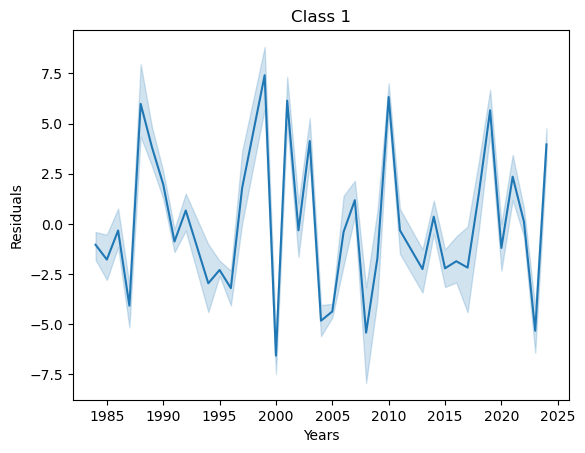

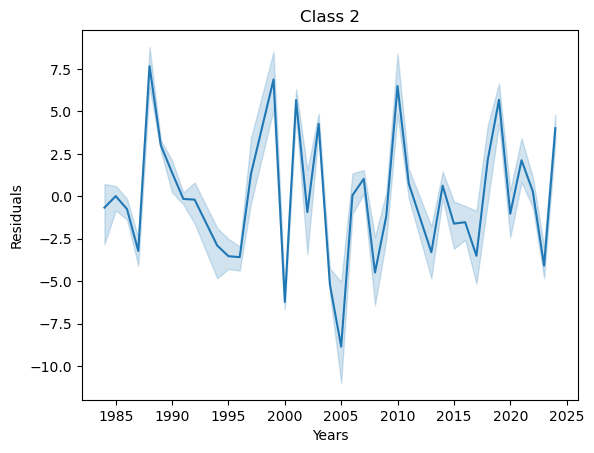

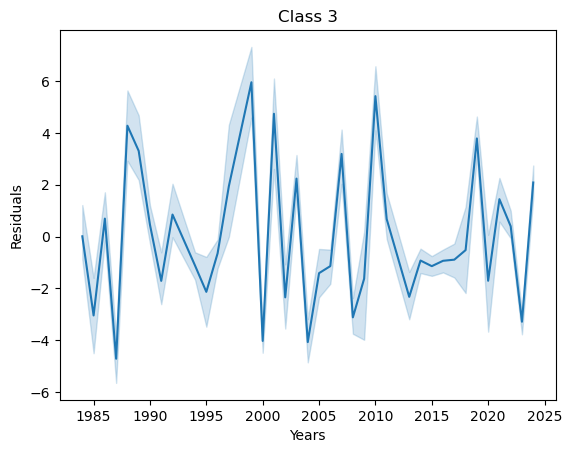

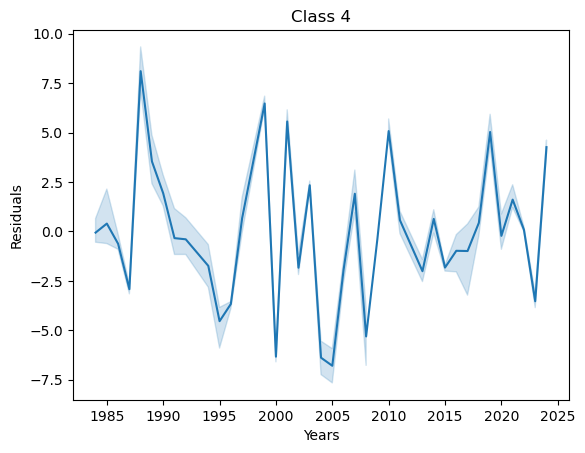

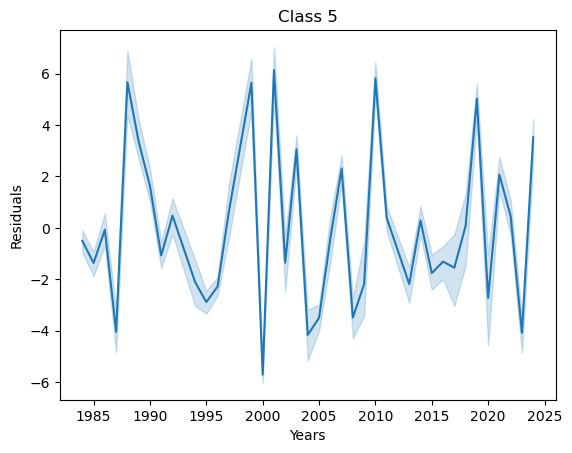

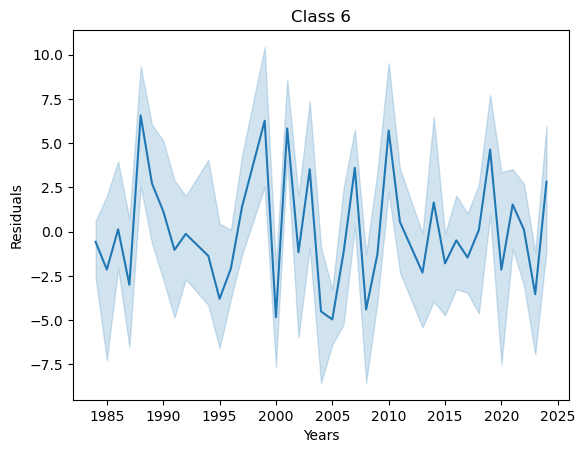

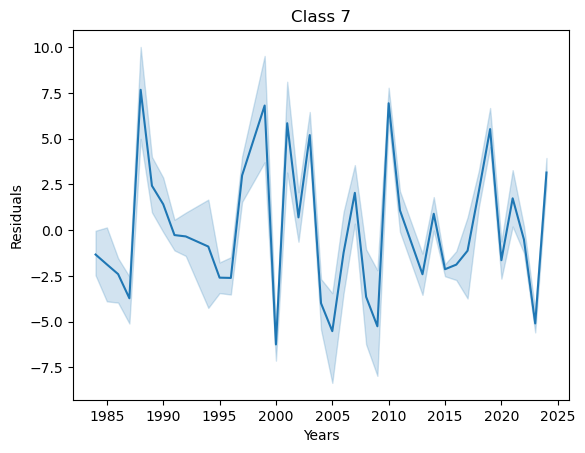

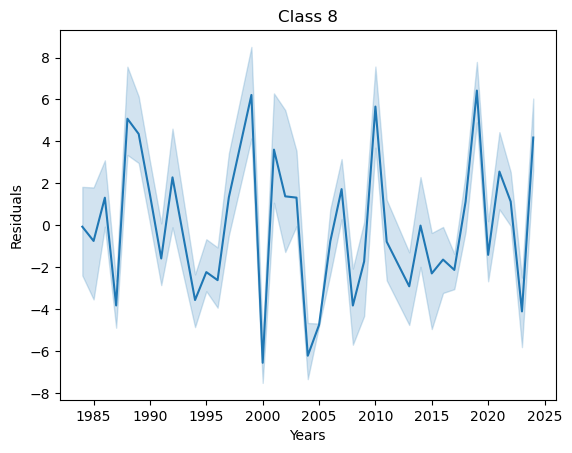

In [ ]:
# Residuals look random

resids = {}

for uniq in lczs:
    actual_data = df_clean.loc[df_clean['lcz'] == uniq].copy()
    trend_data = results_class_df.loc[results_class_df['lcz_class']==uniq].copy()
    actual_data['resids'] = actual_data['mean_LST'] - (actual_data['year'] * trend_data['slope'].iloc[0] + trend_data['intercept'].iloc[0])

    fig, ax = plt.subplots()
    sns.lineplot(data=actual_data, x='year', y='resids', ax=ax)
    ax.set_title('Class '+str(uniq))
    ax.set_xlabel('Years')
    ax.set_ylabel('Residuals')

    resids[uniq] = actual_data['resids'].tolist()

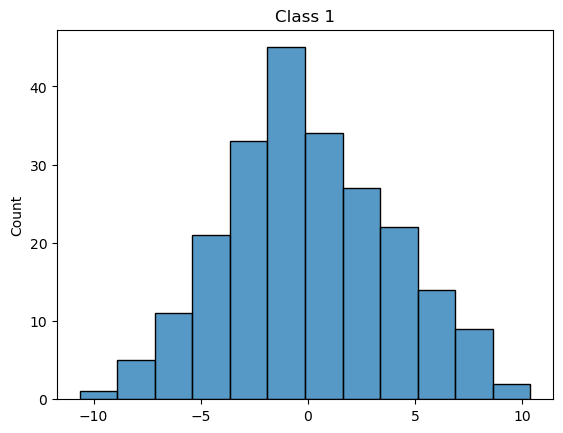

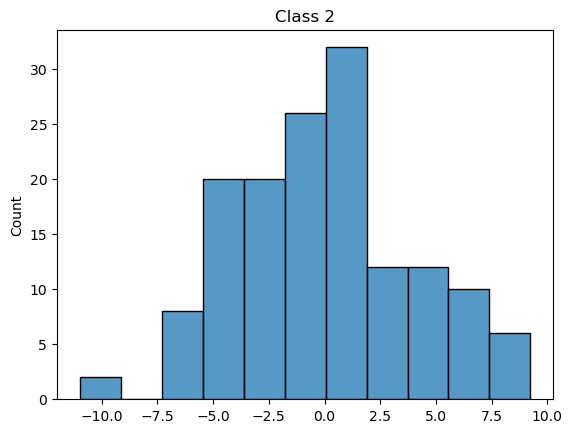

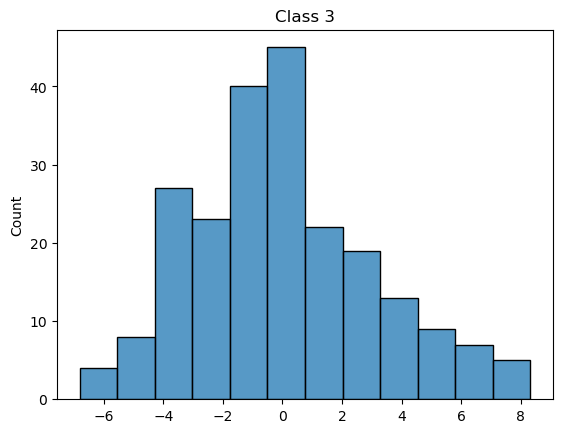

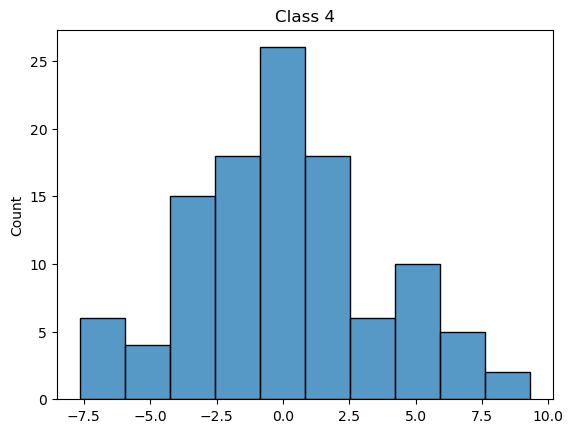

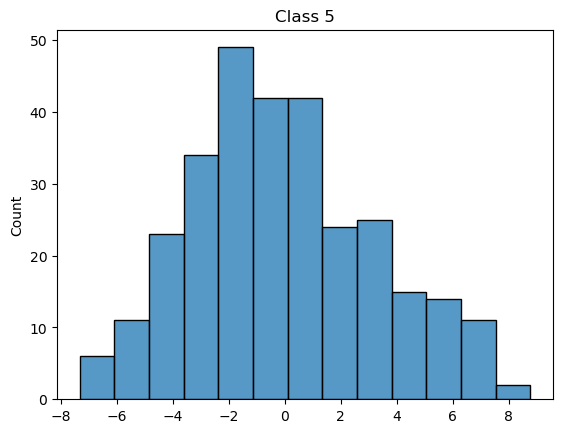

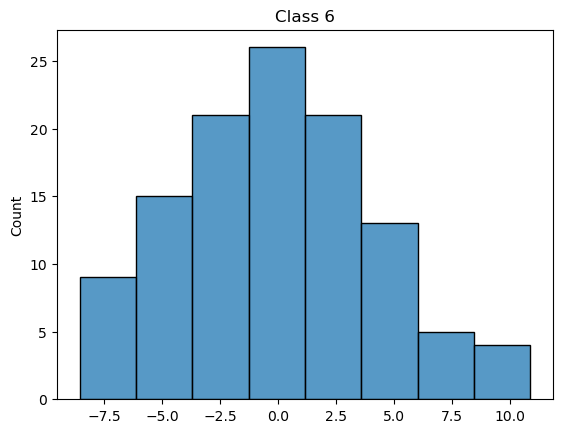

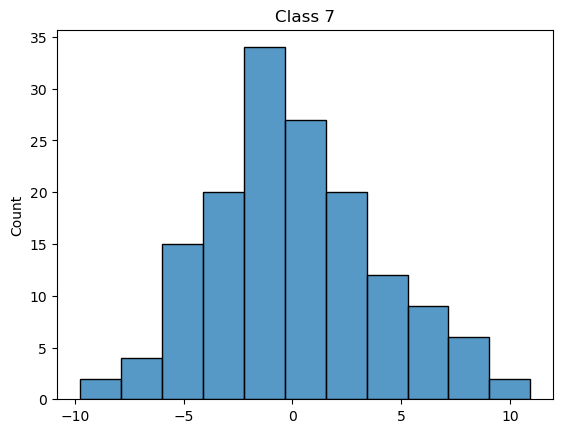

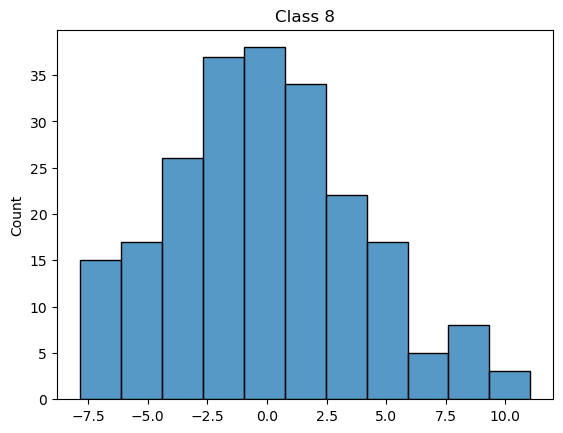

In [ ]:
# Residual histograms (not ideally normal, but normal-like)

for cls in resids.keys():
    resid = resids[cls]
    fig, ax = plt.subplots()
    sns.histplot(resid, ax=ax)
    plt.title(f'Class {cls}')

### Last look at the data

In [ ]:
df_clean

lcz  index  lcz_id            lcz_name   mean_BU   mean_LST  mean_NDBI  \
0       1      0      11            moscvich -0.273184  28.987634  -0.094475   
1       1    145      14         neft_moscow -0.174326  36.866835  -0.024517   
2       1    146      14         neft_moscow -0.164091  38.390080   0.009166   
3       1    147      14         neft_moscow -0.222231  32.338871  -0.073896   
4       1    148      14         neft_moscow -0.134864  36.655693   0.011754   
...   ...    ...     ...                 ...       ...        ...        ...   
1484    8   1371      83  pavshinskaya_poyma -0.711548  21.933764  -0.254613   
1485    8   1372      83  pavshinskaya_poyma -0.795980  28.848171  -0.280431   
1486    8   1373      83  pavshinskaya_poyma -0.581324  30.926988  -0.161283   
1487    8   1361      82          kommunarka -0.602723  33.494963  -0.176106   
1488    8   1519      86             severny -0.338018  41.006480  -0.091853   

                                 en_name  year              classname  
0                       Moskvich Factory  1984       Industrial areas  
1                    Moscow Oil Refinery  2018       Industrial areas  
2                    Moscow Oil Refinery  2019       Industrial areas  
3                    Moscow Oil Refinery  2020       Industrial areas  
4                    Moscow Oil Refinery  2021       Industrial areas  
...                                  ...   ...                    ...  
1484                  Pavshinskaya Poyma  1987  New development areas  
1485                  Pavshinskaya Poyma  1988  New development areas  
1486                  Pavshinskaya Poyma  1989  New development areas  
1487                          Kommunarka  2018  New development areas  
1488  Trade and industrial zone Altufevo  2024  New development areas  

[1489 rows x 10 columns]

In [ ]:
results_class_df

lcz_class              classname  n_points     slope   intercept   r_value  \
0          1       Industrial areas       224  0.133947 -236.019176  0.386917   
1          2                Squares       148  0.101118 -169.290489  0.297494   
2          3           Forest parks       222  0.040040  -57.463339  0.157751   
3          4          Central areas       110  0.103641 -177.594671  0.336920   
4          5       Peripheral areas       298  0.074936 -121.982970  0.264420   
5          6        Landscape parks       114  0.063456  -99.843392  0.176713   
6          7    Redevelopment areas       151  0.037593  -41.954161  0.113037   
7          8  New development areas       222  0.193433 -358.816650  0.505657   

        p_value   std_err  durbin_watson  
0  2.053487e-09  0.021425       2.271459  
1  2.406831e-04  0.026857       2.106767  
2  1.867735e-02  0.016898       2.203238  
3  3.193103e-04  0.027869       2.178822  
4  3.691335e-06  0.015886       2.334221  
5  5.999730e-02  0.033397       1.551717  
6  1.669980e-01  0.027071       1.901091  
7  8.201009e-16  0.022251       1.710332